In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint

In [2]:
# physical constants 
# Create Domain -------------------------------------------------
# physical constants
mu0 = 4*np.pi*10**(-7) # permeability of free space
TeV = 5 # eV
Tk = TeV/1000
eta = 3.3e-8/Tk**(3/2) # plasma resitivity [Ohm-m] (Freidberg eq 11.15)
e = 1.6022e-19 # Coulombs


# Device perameters:
B0 = -350e-4 # magnetic field strength [T] 
R = 0.1#0.5#0.1   # separatrix radius [m]
rc = 1.1  # flux conserving coil radius [m]
w_RMF = 2.2e6# 2*np.pi*14e6 # rad/s  # TODO: get rid of 1000
B_RMF = 120e-4  # RMF field strength
ne = 0.33e20 # m^-3, PFRC value, high end (low end 10^15)

nr = 31  # mesh in r
dr = R/nr
r_array = np.linspace(0, R, nr)
nt = 2*2000#12000#int(12000/2) # number of MHD time steps
dt_MHD = 1e-9*6/2#1e-8  # MHD timestep size, in [s], dt_MHD = 1e-8 works well 
t_array = np.linspace(0, nt*dt_MHD, nt)
timestep_save_interval = 5 # The number of timesteps to skip saving between saved timesteps. 
if timestep_save_interval >= nt:
    raise ValueError('Spacing between saved timesteps cannot be larger than nt') 
#pdb.set_trace()
nphi = 30
dphi = 2*np.pi/nphi
phi_array = np.linspace(0, 2*np.pi, nphi)

A_Z = np.zeros((nt, nr), dtype ='complex_')  # create A_Z time evolution holder 
B_Z = np.zeros((nt, nr), dtype ='complex_')  # create B_Z time evolution holder 

# initial condition for n == 0 mode
B_Z_t0 = B0*(1-2*(r_array/R)**2)
B_Z[0, :] = B_Z_t0
# A_Z at t=0 is 0. No need to change anything 

# solve for Bz0, used in boundary condition, equation (12) in Quals paper
beta = B_Z_t0[-1]
gamma = np.trapz(B_Z_t0*r_array, dx=dr)
Bz0 = (beta*(rc**2 - R**2) + 2*gamma)/rc**2


In [3]:
gamma = B_RMF / (ne*e*eta)
print(gamma)

24.315972603322898


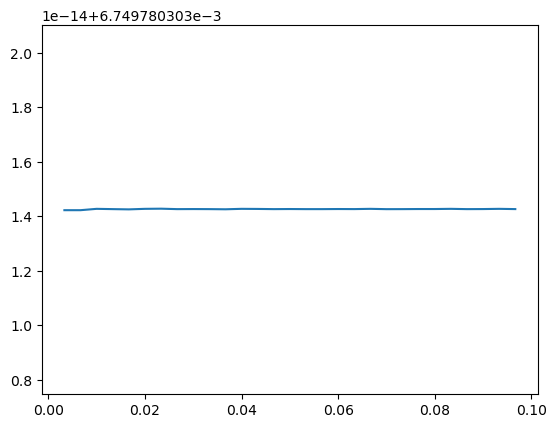

In [4]:
# Plot the factor 
dB_dr = np.gradient(B_Z_t0, dr)
factor_array = np.zeros_like(dB_dr[:-1])
%matplotlib inline  
for i in range(1, dB_dr.shape[0]):
    factor_array[i-1] = dt_MHD*dB_dr[i]*(1/(i*dr))/(ne*e*mu0)
plt.plot(r_array[1:-1], factor_array[:-1])

c:\Users\jacob\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Be Sure dt_MHD << $\\pi$/4')

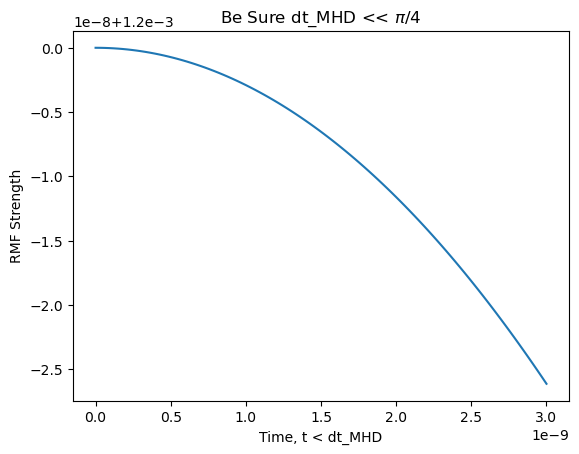

In [5]:
#plotting the RMF:
t_array2 = np.linspace(0, dt_MHD, 100)
RMF_array = R*B_RMF*np.cos(w_RMF*t_array2) + 1j*np.sin(w_RMF*t_array2)
plt.plot(t_array2, RMF_array)
plt.xlabel('Time, t < dt_MHD')
plt.ylabel(r'RMF Strength')
plt.title('Be Sure dt_MHD << $\pi$/4')

Text(0.5, 1.0, 'Visualizing how many cycles occur')

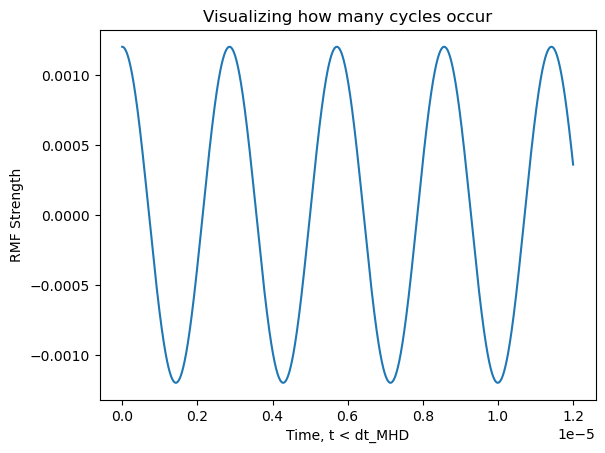

In [6]:
#plotting the RMF over full time:

RMF_array2 = R*B_RMF*np.cos(w_RMF*t_array) + 1j*np.sin(w_RMF*t_array)
plt.plot(t_array, RMF_array2)
plt.xlabel('Time, t < dt_MHD')
plt.ylabel(r'RMF Strength')
plt.title('Visualizing how many cycles occur')

In [7]:
dt_crit = dr**2/(2*eta/mu0)
print('Max time step: ', dt_crit)
print('Your time step: ', dt_MHD)
print(f'Number of peroids: {nt*dt_MHD / (2*np.pi/w_RMF)}T')

t_Hall = ne*e*mu0*R**2/(abs(B0))
t_diffusion = mu0*R**2/eta
print('The characteristic diffusion timescale is: ', t_diffusion)
print('The characteristic Hall timescale is: ', t_Hall)

print('Total sim time: ', nt*dt_MHD)

factor = dt_MHD/(ne*e*mu0)
print('Factor: ', factor)
d_skin = np.sqrt(2*eta/(mu0*w_RMF))

print('Skin Depth: ', d_skin)
print('dr: ', dr)

k_c = -2#int(nr/2)
dBdr_max = (B_Z_t0[k_c + 1] - B_Z_t0[k_c - 1]) / (2*dr)
amplification_factor = dBdr_max * dt_MHD/(ne*e*mu0*dr*nr) #(ne*e*mu0*dr*nr)
print('Amp: ', amplification_factor)
print(dt_MHD/amplification_factor)
t_Hall_skin_depth = ne*e*mu0*d_skin**2/(abs(B0))
print('The characteristic Hall timescale is with skin depth as characteristic: ', t_Hall_skin_depth)

Max time step:  7.00482915233243e-08
Your time step:  3.0000000000000004e-09
Number of peroids: 4.201690497626037T
The characteristic diffusion timescale is:  0.0001346328163078293
The characteristic Hall timescale is:  1.8983333912707625e-06
Total sim time:  1.2000000000000002e-05
Factor:  0.00045152387935876626
Skin Depth:  0.008217282014862515
dr:  0.0032258064516129032
Amp:  0.006314310606232701
4.75111249205697e-07
The characteristic Hall timescale is with skin depth as characteristic:  1.2818253942501889e-08


In [8]:
# create the diffusion equation matrix 
def get_C_plus(k):
    return (dt_MHD*eta/(dr**2*mu0))*(1 + (1/(2*k)))

def get_C_minus(k):
    return (dt_MHD*eta/(dr**2*mu0))*(1 - (1/(2*k)))

def get_C_0(k, m):
    # rk = dr*k
    # front = dt_MHD*eta/mu0
    # in1 = 2/dr**2
    # in2 = m**2/rk**2
    # return 1 -front*(in1 + in2)
    rk = dr*k
    front = dt_MHD*eta/mu0
    in1 = 2/dr**2
    in2 = m**2/rk**2
    return -front*(in1 + in2)

# load up a_z matrix, ignoring boundary conditions initially 
def get_Dmat_m(m):
    Dmat = np.zeros((nr-2, nr-2), dtype ='complex_')  # only on iterior nodes
    
    for k in range(0, Dmat.shape[0]):
        # get methods called for k+1 because Dmat only exists for the interior nodes
        Dmat[k, k] = get_C_0(k+1, m)
        if k != 0:
            Dmat[k, k-1] = get_C_minus(k+1)
        if k != (Dmat.shape[0] - 1):
            Dmat[k, k + 1] = get_C_plus(k+1)
            
    #process boundary conditions by remaking C0 at the extrema of Dmat
    
    # derivative of A at r=0 = 0 for m = 0. if m = 1, do nothing as Dmat[0, 0] = get_C_0(1, n)
    #Dmat[0, 0] = get_C_0(1, m) + get_C_minus(1)
    if m == 0:
        Dmat[0, 0] = get_C_0(1, m) + (4/3)*get_C_minus(1)
        Dmat[0, 1] = get_C_plus(1) - (1/3)*get_C_minus(1)
    
    # boundary condition at r = R: drive term on mode 1, vacuum boundary for m != 1
    if m == 0:
        Dmat[-1, -1] = get_C_0(nr-2, m) + get_C_plus(nr-2)
    else: 
        term = (R/(m*dr))/(1 + R/(m*dr))
        Dmat[-1, -1] = get_C_0(nr-2, m) + get_C_plus(nr-2)*term
        # note: S_m must be updated for m = 1 to complete boundary condition for drive term 
    return Dmat
 
def get_Bmat_n(n): 
    # solves for the finite difference matrix for the nth mode of B
    Bmat = np.zeros((nr-2, nr-2), dtype ='complex_')  # only on iterior nodes
    
    for k in range(0, Bmat.shape[0]):
        # get methods called for k+1 because Bmat only exists for the interior nodes
        Bmat[k, k] = get_C_0(k+1, n)
        if k != 0:
            Bmat[k, k-1] = get_C_minus(k+1)
        if k != (Bmat.shape[0] - 1):
            Bmat[k, k + 1] = get_C_plus(k+1)
            
    #process boundary conditions by remaking C0 at the extrema of Bmat
    
    # derivative of B at r=0 = 0 for n = 0. if n = 1, do nothing as Bmat[0, 0] = get_C_0(1, n)
    #Bmat[0, 0] = get_C_0(1, n) + get_C_minus(1)
    if n == 0:
        Bmat[0, 0] = get_C_0(1, n) + (4/3)*get_C_minus(1)
        Bmat[0, 1] = get_C_plus(1) - (1/3)*get_C_minus(1)
        
    # boundary condition at r = R: flux conservation for n == 0
    if n == 0:
        Bmat[-1, -1] = get_C_0(nr-2, n)
        # note: V_m must be updated for n = 1 to complete boundary condition for drive term 
    else: 
        Bmat[-1, -1] = get_C_0(nr-2, n)  # there is no theta variation in vacuume
    return Bmat

In [9]:
def get_convolution_indicies(m, n_array):
    """Helper function which returns n_array_short, m_minus_n_array
       which contain the indicies to actully perform the convolution over --
       this insures they are all modes that are actually solved for. 
    """
    maxn = max(abs(n_array))
    m_minus_n = m - n_array
    n_holder = []
    m_minus_n_holder = []
    for i in range(m_minus_n.shape[0]):
        if abs(m_minus_n[i]) <= maxn:
            m_minus_n_holder.append(m_minus_n[i])
            n_holder.append(n_array[i])
    return np.array(n_holder), np.array(m_minus_n_holder)


In [11]:
def hall_Az_Sm_updater3(m, S_m, Az_t_minus_one, Bz_t_minus_one, n_array, m_array, dt, dr):
    # this version is written with John Wright's version of the Hall term and compatible with 
    # skipping times 
    S_m_interior = S_m[1:-1]
    for i in range(S_m_interior.shape[0]):
        k = i + 1 # i starts at zero, but we are in interior nodes so i = 0 is k = 1
        rk = dr*(k) 
        sum1 = 0
        #extract convolution terms for modes that we have access to. 
        n_array_short, m_minus_n = get_convolution_indicies(m, n_array) 
        for i_n in range((n_array_short.shape[0])):
            n = n_array_short[i_n]
            m_n = m_minus_n[i_n]
            i_m = np.where(m_array == n)[0][0] # get index for extracting A_n 
            i_m_n = np.where(n_array == m_n)[0][0] # get index for extracting B_m_n
            A_n = Az_t_minus_one[i_m]
            B_m_n = Bz_t_minus_one[i_m_n]
            
            dBdr = (B_m_n[0, k+1] - B_m_n[0, k-1])/(2*dr)
            dAdr = (A_n[0, k+1] - A_n[0, k-1])/(2*dr)
            term1 = 1j*n*A_n[0, k]*dBdr / rk   #TODO: bring this back!!
            term2 = 1j*(m - n)*B_m_n[0, k]*dAdr / rk
            sum1 = sum1 + term1 - term2
        #print('---')
        #print(sum1*(-dt_MHD/(ne*mu0*e)))
#         if sum1 != 0:
#             print('IT ISNT ZERO')
        S_m_interior[i] = sum1*(-dt_MHD/(ne*mu0*e))
    # update all of S_m's interior nodes 
    S_m[1:-1] = S_m_interior   
    return S_m

# TODO: for now, I am making this function only work on interior interior nodes 
def hall_Bz_Vn_updater3(m, V_n, Az_t_minus_one, m_array, dt_MHD, dr):
    #This function works with solve_a_z_b_z_skip_time(). It performs an A convolution and 
    #calcluates the Hall term for the dBz/dt equation:
    #  (1/nemu0)*div(cross(Az*zhat, grad(laplacian(Az))))
    #V_n_interior = V_n[1:-1] TODO: switch back
    V_n_interior = V_n[2:-2]
    for i in range(V_n_interior.shape[0]):
        #k = i + 1 # i starts at zero, but we are in interior nodes so i = 0 is k = 1 TODO: switch back
        k = i + 2 # i starts at zero, but we are in interior nodes so i = 0 is k = 1
        rk = dr*(k) 

        #initiate running sum over nodes at each spatial index i
        sum1 = 0
        #extract convolution terms for modes that we have access to. 
        n_array_short, m_minus_n = get_convolution_indicies(m, m_array) # TODO: carfully think about this
        for i_n in range((n_array_short.shape[0])):
            n = n_array_short[i_n]
            m_n = m_minus_n[i_n]
            i_m = np.where(m_array == n)[0][0] # get index for extracting A_n 
            i_m_n = np.where(m_array == m_n)[0][0] # get index for extracting A_m_n
            A_n = Az_t_minus_one[i_m]
            A_m_n = Az_t_minus_one[i_m_n]
            
            # terms from notes 
            alpha = 1j*n*A_n[0, k] / rk
            delta = (A_n[0, k+1] - A_n[0, k-1]) / (rk * 2 * dr)
            term1 = (1j*(m_n))**2*A_m_n[0, k+1]/(rk + dr)**2
            term2 = (1j*(m_n))**2*A_m_n[0, k-1]/(rk - dr)**2   # TODO: issue with interior nodes 
            #print(f'TERM 2: {term2}')
            beta2 = (1/(2*dr))*(term1 - term2) 
            gamma2 = (1/rk**2)*(1j*m_n)**3*A_m_n[0, k]

            term3 = (rk + dr/2)*(A_m_n[0, k+1] - A_m_n[0, k])/dr
            term4 = (rk - dr/2)*(A_m_n[0, k] - A_m_n[0, k-1])/dr
            gamma1 = (1/rk*dr)*1j*m_n*(term3 - term4)

            # working on 3rd derivative term: for now only add to V_n[2:-2] in order to avoid looking 2 ahead in r (out of range)
            if i > 0 and i < V_n_interior.shape[0] - 1:
                r_dAdr_3_2 = (rk + dr*1.5)*(A_m_n[0, k+2] - A_m_n[0, k+1]) / dr
                r_dAdr_1_2 = (rk + dr*0.5)*(A_m_n[0, k+1] - A_m_n[0, k]) / dr

                r_dAdr_n1_2 = (rk - dr*0.5)*(A_m_n[0, k] - A_m_n[0, k-1]) / dr
                r_dAdr_n3_2 = (rk - dr*1.5)*(A_m_n[0, k-1] - A_m_n[0, k-2]) / dr

                beta1 = (1/(2*dr))*((r_dAdr_3_2 - r_dAdr_1_2)/((rk + dr)*dr) - (r_dAdr_n1_2 - r_dAdr_n3_2)/((rk - dr)*dr))

            else:
                beta1 = 0 #TODO: fix this!!
            
#             big_number = 1e2
#             big_array = np.array([alpha, beta1, beta2, delta, gamma1, gamma2])
#             variable_names = ['alpha', 'beta1', 'beta2', 'delta', 'gamma1', 'gamma2']
#             if max(abs(big_array)) > big_number:
#                 print('big_array:')
#                 print(big_array)
#                 print(variable_names)
#                 raise ValueError('derp')
#                 #raise ValueError(f'{variable_names[idx]}: {big_array[idx]}')
#             beta1 = 1 # TODO: TODOTODO remove!!!!!!!!!!!!!!!!
            
            
            sum1 = sum1 + (dt_MHD/(ne*e*mu0)) * (alpha*beta1*beta2 + delta*gamma1*gamma2)

        # assign the sum total over all the phi modes to the ith interior index of 
        V_n_interior[i] = sum1
    # update all of S_m's interior nodes 
    # V_n[1:-1] = V_n_interior   #TODO: switch back
    V_n[2:-2] = V_n_interior
    return V_n     
            

def find_average_two_lists(list1, list2):
    list3 = list1.copy()
    for i in range(len(list1)):
        list3[i] = 0.5*(list1[i] * list2[i])
    return list3


def solve_a_z_b_z_skip_time(A_z_hold, B_z_hold, m_array, n_array, timestep_save_interval, num_PC_steps): 
    """
    A_z_hold and m_array should be the same shape. Same with B_z_hold and n_array. 
    The function takes in a list of matricies for the M modes of AZ and the N modes 
    of BZ. Each mode matrix should be one row initially, this row being the initial condition.  
    
    timestep_save_interval: int. only times which are multiples of timestep_save_interval will be saved.  
    
    returns: A_z_hold, B_z_hold after time simulation. The ith row of matrix A_z_hold[j]
    is the r-difference domain at time t = i*dt_MHD for mode m_array[j].  
    """
    # load up initial conditions 
    Az_t_minus_one = A_z_hold.copy()
    Bz_t_minus_one = B_z_hold.copy()
    Az_t = A_z_hold.copy()
    Bz_t = B_z_hold.copy()

    # PC intermediate mode holder 
    Az_s = A_z_hold.copy()
    Bz_s = B_z_hold.copy()
    k1_mode_holder = np.zeros_like(m_array, dtype=object)
    c1_mode_holder = np.zeros_like(n_array, dtype=object)
    am_old_mode_holder = np.zeros_like(m_array, dtype=object)
    bn_old_mode_holder = np.zeros_like(n_array, dtype=object)
    
#     # load up with zeros for now
#     for i in range(len(Az_t)):
#         Az_t[i] = 0
#     for i in range(len(Az_t)):
#         Bz_t[i] = 0
        
    t_array_new = np.array([0]) # to be filled with the times that are saved 
    for it in range(t_array.shape[0]-1):
        print('Percent Complete: ', 100*it/nt)
        t = it*dt_MHD
        
        # update the time holder array if this is a saved step
        if (it % timestep_save_interval == 0) and (it != 0):
            t_array_new = np.append(t_array_new, it*dt_MHD)
        # work on the mth mode of A_Z first

        # new predictor-corrector section 
        # A_z_s = Az_t_minus_one.copy()
        # B_z_s = Bz_t_minus_one.copy()


        # TODO: TODO TODO TODO TODO LOOP 1
        # loop through the modes in m for the predictor step. Dont update the mode holder. 
        for i_m in range(m_array.shape[0]):
            m = m_array[i_m]
            a_zm = Az_t_minus_one[i_m]  # use from previous time step
            a_zm_t = np.zeros_like(a_zm, dtype ='complex_') # storage for after matrix multiplication 
            #print(a_zm.shape)
            a_zm = a_zm[0, 1:-1] # keep interior nodes
            a_zm.shape = (nr-2, 1) # recast into collumn vector
            #create S_m array 
            S_m = np.zeros((nr-2, 1), dtype ='complex_')

            # get the stencile diff matrix 
            Dmatm = get_Dmat_m(m)
            #add in Hall term to S_m
            S_m = hall_Az_Sm_updater3(m, S_m, Az_t_minus_one, Bz_t_minus_one, n_array, m_array, dt_MHD, dr)
            #S_m2 = hall_Az_Sm_updater3(m, S_m, A_z_s, B_z_s, n_array, m_array, dt_MHD, dr)  # use the A_z_s values within the pc step
            #S_m = 0.5 * (S_m1 + S_m2) # predictor corrector 
            if m == 1:
                alpha_1 = R*B_RMF*np.exp(-1j*w_RMF*t)/(2) 
                S_m[-1] = 2*alpha_1*get_C_plus(nr-2)/(1 + R/(m*dr))
            elif m == -1:
                alpha_1 = -R*B_RMF*np.exp(1j*w_RMF*t)/(2) 
                S_m[-1] = 2*alpha_1*get_C_plus(nr-2)/(1 + R/(m*dr))

            # advance the mth mode
            k1 = np.matmul(Dmatm, a_zm) + S_m
            k1_mode_holder[i_m] = k1
            am_old_mode_holder[i_m] = a_zm
            a_zm = a_zm + k1
            # load up into the next timestep 
#             print('a_zm.T shape:', a_zm.T.shape)
#             print('a_zm_t[0, 1:-1] shape:', a_zm_t[0, 1:-1].shape)
            a_zm_t[0, 1:-1] = a_zm.T
            # boundary condition at r = 0: slope is zero for m = 0, value is zero for m != 0
            #A_Zm[it + 1, 0] = A_Zm[it + 1, 1]
            if m == 0:
                a_zm_t[0, 0] = (4/3)*a_zm_t[0, 1] - (1/3)*a_zm_t[0, 2]
            else: 
                a_zm_t[0, 0] = 0
                
            #boundary condtion at r = R:
            if m == 0:
                a_zm_t[0, -1] = a_zm_t[0, -2]
            elif m == 1:
                alpha_1 = R*B_RMF*np.exp(-1j*w_RMF*t)/(2) 
                a_zm_t[0, -1] = 2*alpha_1/(1 + R/(m*dr)) + (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))
            elif m == -1:
                alpha_1 = -R*B_RMF*np.exp(1j*w_RMF*t)/(2) #TODO should be negative
                a_zm_t[0, -1] = 2*alpha_1/(1 + R/(m*dr)) + (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))
            else: 
                a_zm_t[0, -1] =  (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))

            # update the holder array 
            Az_s[i_m] = a_zm_t
            # load up the mth mode if it is a multiple of time_step
#             if (it % timestep_save_interval == 0) and (it != 0): # and (s == num_PC_steps-1):
# #                 print('A_z_hold[i_m].shape: ', A_z_hold[i_m].shape)
# #                 print('a_zm_t.shape', a_zm_t.shape)
#                 A_z_hold[i_m] = np.concatenate((A_z_hold[i_m], a_zm_t), axis=0)
        
        
        # reset the old values to the new ones for the next timestep's iteration over the Az modes 
    
        # now work on the nth mode of B_Zn
        # TODO: TODO TODO TODO TODO LOOP 2
        for i_n in range(n_array.shape[0]):
            n = n_array[i_n]
            b_zn = Bz_t_minus_one[i_n]
            #initial condition must be included as first row of mode n
            b_zn_t = np.zeros_like(b_zn, dtype ='complex_') # storage for after matrix multiplication 
            b_zn = b_zn[0, 1:-1] # keep interior nodes
            b_zn.shape = (nr-2, 1) # recast into collumn vector

            #create V_n array 
            V_n = np.zeros((nr-2, 1), dtype ='complex_')

            # get the stencile diff matrix 
            Bmatn = get_Bmat_n(n)

            # add Hall term to V_n TODO: this function currently does not return anything
            #                         (m, V_n, Az_t_minus_one, m_array, it, dt_MHD, dr):
            V_n = hall_Bz_Vn_updater3(n, V_n, Az_t_minus_one, m_array, dt_MHD, dr)
            #V_n2 = hall_Bz_Vn_updater3(n, V_n, A_z_s, m_array, dt_MHD, dr)
            #V_n = 0.5*(V_n1 + V_n2)
            #print(V_n)
            # update V_n with boundary condition if n == 0
            if n == 0:
                term1 = rc**2*Bz0/(rc**2 - R**2)
                term2 = 1/(np.pi*(rc**2 - R**2))
                V_n[-1] = get_C_plus(nr-2)*(term1 - \
                        2*np.pi*term2*np.trapz(b_zn.T*r_array[1:-1], dx=dr)) # flux conserving boundary
            else:
                V_n[-1] = 0  # all other BZ mode numbers are zero at plasma boundary: no vacuum currents

            c1 = np.matmul(Bmatn, b_zn) + V_n
            c1_mode_holder[i_n] = c1
            bn_old_mode_holder[i_n] = b_zn
            b_zn = b_zn + c1
            
            # load up time history 
            b_zn_t[0, 1:-1] = b_zn.T
            
            # boundary condition at r = 0: slope is zero for n = 0, value is zero for n != 0 
            #B_Z[it + 1, 0] = B_Z[it + 1, 1]
            if n == 0:  # TODO: this is a new addition to the code. used to be that n==0 bc was only bc.  
                b_zn_t[0, 0] = (4/3)*b_zn_t[0, 1] - (1/3)*b_zn_t[0, 2]
            else:
                b_zn_t[0, 0] = 0
            #boundary condtion at r = R:
            if n == 0:
                term1 = rc**2*Bz0/(rc**2 - R**2)
                term2 = 1/(np.pi*(rc**2 - R**2))
                #print('b_zn.shape: ', b_zn.shape)
                b_zn_t[0, -1] = term1 - \
                                2*np.pi*term2*np.trapz(b_zn.T*r_array[1:-1], dx=dr) # flux conserving boundary
            else: 
                b_zn_t[0, -1] =  0 # all other mode numbers are zero at plasma boundary: no vacuum currents

            # load up the nth mode
            #TODO: SWITCH THIS BACK FOR BZ TIME EVOLUTION 
            #---------------------------------------------------
            #TODO: REMOVE THIS, this just freezes B 
#             if n == 0:
#                 b_zn_t[0, :] = B_Z_t0  
#             else:
#                 b_zn_t[0, :] = B_Z_t0*0
            #---------------------------------------------------
            # update the holder array for the nth mode  
            Bz_s[i_n] = b_zn_t


        # reset the old values to the new ones for the next timestep's iteration over the Az modes 
        # loop through the modes in m for the predictor step. update the mode holder. 
        # TODO: TODO TODO TODO TODO LOOP 3
        # loop through the modes in m for the predictor step. Dont update the mode holder. 
#         for i_m in range(m_array.shape[0]):
#             m = m_array[i_m]
#             a_zm = Az_s[i_m]  # use from previous time step
#             a_zm_t = np.zeros_like(a_zm, dtype ='complex_') # storage for after matrix multiplication 
#             #print(a_zm.shape)
#             a_zm = a_zm[0, 1:-1] # keep interior nodes
#             a_zm.shape = (nr-2, 1) # recast into collumn vector
#             #create S_m array 
#             S_m = np.zeros((nr-2, 1), dtype ='complex_')

#             # get the stencile diff matrix 
#             Dmatm = get_Dmat_m(m)
#             #add in Hall term to S_m
#             S_m = hall_Az_Sm_updater3(m, S_m, Az_s, Bz_s, n_array, m_array, dt_MHD, dr)
#             #S_m2 = hall_Az_Sm_updater3(m, S_m, A_z_s, B_z_s, n_array, m_array, dt_MHD, dr)  # use the A_z_s values within the pc step
#             #S_m = 0.5 * (S_m1 + S_m2) # predictor corrector 
#             if m == 1:
#                 alpha_1 = R*B_RMF*np.exp(-1j*w_RMF*(t+dt_MHD))/(2) 
#                 S_m[-1] = 2*alpha_1*get_C_plus(nr-2)/(1 + R/(m*dr))
#             elif m == -1:
#                 alpha_1 = -R*B_RMF*np.exp(1j*w_RMF*(t+dt_MHD))/(2) 
#                 S_m[-1] = 2*alpha_1*get_C_plus(nr-2)/(1 + R/(m*dr))

#             # advance the mth mode
#             k1 = k1_mode_holder[i_m]
#             k2 = np.matmul(Dmatm, a_zm) + S_m
#             a_zm_old = am_old_mode_holder[i_m]
#             a_zm = a_zm_old + 0.5*(k1 + k2)
#             # load up into the next timestep 
# #             print('a_zm.T shape:', a_zm.T.shape)
# #             print('a_zm_t[0, 1:-1] shape:', a_zm_t[0, 1:-1].shape)
#             a_zm_t[0, 1:-1] = a_zm.T
#             # boundary condition at r = 0: slope is zero for m = 0, value is zero for m != 0
#             #A_Zm[it + 1, 0] = A_Zm[it + 1, 1]
#             if m == 0:
#                 a_zm_t[0, 0] = (4/3)*a_zm_t[0, 1] - (1/3)*a_zm_t[0, 2]
#             else: 
#                 a_zm_t[0, 0] = 0
                
#             #boundary condtion at r = R:
#             if m == 0:
#                 a_zm_t[0, -1] = a_zm_t[0, -2]
#             elif m == 1:
#                 alpha_1 = R*B_RMF*np.exp(-1j*w_RMF*t)/(2) 
#                 a_zm_t[0, -1] = 2*alpha_1/(1 + R/(m*dr)) + (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))
#             elif m == -1:
#                 alpha_1 = -R*B_RMF*np.exp(1j*w_RMF*t)/(2) #TODO should be negative
#                 a_zm_t[0, -1] = 2*alpha_1/(1 + R/(m*dr)) + (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))
#             else: 
#                 a_zm_t[0, -1] =  (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))

#             # update the holder array 
#             Az_s[i_m] = a_zm_t
#             # load up the mth mode if it is a multiple of time_step
# #             if (it % timestep_save_interval == 0) and (it != 0): # and (s == num_PC_steps-1):
# # #                 print('A_z_hold[i_m].shape: ', A_z_hold[i_m].shape)
# # #                 print('a_zm_t.shape', a_zm_t.shape)
# #                 A_z_hold[i_m] = np.concatenate((A_z_hold[i_m], a_zm_t), axis=0)
        
        
#         # reset the old values to the new ones for the next timestep's iteration over the Az modes 
    
#         # now work on the nth mode of B_Zn
#         # TODO: TODO TODO TODO TODO LOOP 4
#         for i_n in range(n_array.shape[0]):
#             n = n_array[i_n]
#             b_zn = Bz_s[i_n]
#             #initial condition must be included as first row of mode n
#             b_zn_t = np.zeros_like(b_zn, dtype ='complex_') # storage for after matrix multiplication 
#             b_zn = b_zn[0, 1:-1] # keep interior nodes
#             b_zn.shape = (nr-2, 1) # recast into collumn vector

#             #create V_n array 
#             V_n = np.zeros((nr-2, 1), dtype ='complex_')

#             # get the stencile diff matrix 
#             Bmatn = get_Bmat_n(n)

#             # add Hall term to V_n TODO: this function currently does not return anything
#             #                         (m, V_n, Az_t_minus_one, m_array, it, dt_MHD, dr):
#             V_n = hall_Bz_Vn_updater3(n, V_n, Az_s, m_array, dt_MHD, dr)
#             #V_n2 = hall_Bz_Vn_updater3(n, V_n, A_z_s, m_array, dt_MHD, dr)
#             #V_n = 0.5*(V_n1 + V_n2)
#             #print(V_n)
#             # update V_n with boundary condition if n == 0
#             if n == 0:
#                 term1 = rc**2*Bz0/(rc**2 - R**2)
#                 term2 = 1/(np.pi*(rc**2 - R**2))
#                 V_n[-1] = get_C_plus(nr-2)*(term1 - \
#                         2*np.pi*term2*np.trapz(b_zn.T*r_array[1:-1], dx=dr)) # flux conserving boundary
#             else:
#                 V_n[-1] = 0  # all other BZ mode numbers are zero at plasma boundary: no vacuum currents

#             c1 = c1_mode_holder[i_n]
#             c2 = np.matmul(Bmatn, b_zn) + V_n
#             b_zn_old = bn_old_mode_holder[i_n]
#             b_zn = b_zn_old + 0.5*(c1 + c2)
            
#             # load up time history 
#             b_zn_t[0, 1:-1] = b_zn.T
            
#             # boundary condition at r = 0: slope is zero for n = 0, value is zero for n != 0 
#             #B_Z[it + 1, 0] = B_Z[it + 1, 1]
#             if n == 0:  # TODO: this is a new addition to the code. used to be that n==0 bc was only bc.  
#                 b_zn_t[0, 0] = (4/3)*b_zn_t[0, 1] - (1/3)*b_zn_t[0, 2]
#             else:
#                 b_zn_t[0, 0] = 0
#             #boundary condtion at r = R:
#             if n == 0:
#                 term1 = rc**2*Bz0/(rc**2 - R**2)
#                 term2 = 1/(np.pi*(rc**2 - R**2))
#                 #print('b_zn.shape: ', b_zn.shape)
#                 b_zn_t[0, -1] = term1 - \
#                                 2*np.pi*term2*np.trapz(b_zn.T*r_array[1:-1], dx=dr) # flux conserving boundary
#             else: 
#                 b_zn_t[0, -1] =  0 # all other mode numbers are zero at plasma boundary: no vacuum currents

            # load up the nth mode
            #TODO: SWITCH THIS BACK FOR BZ TIME EVOLUTION 
            #---------------------------------------------------
            #TODO: REMOVE THIS, this just freezes B 
#             if n == 0:
#                 b_zn_t[0, :] = B_Z_t0  
#             else:
#                 b_zn_t[0, :] = B_Z_t0*0
            #---------------------------------------------------
            # update the holder array for the nth mode  
            Bz_s[i_n] = b_zn_t

        # TODO: TODO TODO TODO TODO LOOP 5
        for i_m in range(m_array.shape[0]):
            m = m_array[i_m]
            a_zm = Az_s[i_m]  # use from previous time step
            a_zm_t = np.zeros_like(a_zm, dtype ='complex_') # storage for after matrix multiplication 
            #print(a_zm.shape)
            a_zm = a_zm[0, 1:-1] # keep interior nodes
            a_zm.shape = (nr-2, 1) # recast into collumn vector
            #create S_m array 
            S_m = np.zeros((nr-2, 1), dtype ='complex_')

            # get the stencile diff matrix 
            Dmatm = get_Dmat_m(m)
            #add in Hall term to S_m
            S_m = hall_Az_Sm_updater3(m, S_m, Az_s, Bz_s, n_array, m_array, dt_MHD, dr)
            #S_m2 = hall_Az_Sm_updater3(m, S_m, A_z_s, B_z_s, n_array, m_array, dt_MHD, dr)  # use the A_z_s values within the pc step
            #S_m = 0.5 * (S_m1 + S_m2) # predictor corrector 
            if m == 1:
                alpha_1 = R*B_RMF*np.exp(-1j*w_RMF*(t+dt_MHD))/(2) 
                S_m[-1] = 2*alpha_1*get_C_plus(nr-2)/(1 + R/(m*dr))
            elif m == -1:
                alpha_1 = -R*B_RMF*np.exp(1j*w_RMF*(t+dt_MHD))/(2) 
                S_m[-1] = 2*alpha_1*get_C_plus(nr-2)/(1 + R/(m*dr))

            # advance the mth mode
            k1 = k1_mode_holder[i_m]
            k2 = np.matmul(Dmatm, a_zm) + S_m
            a_zm_old = am_old_mode_holder[i_m]
            a_zm = a_zm_old + 0.5*(k1 + k2)
            # load up into the next timestep 
#             print('a_zm.T shape:', a_zm.T.shape)
#             print('a_zm_t[0, 1:-1] shape:', a_zm_t[0, 1:-1].shape)
            a_zm_t[0, 1:-1] = a_zm.T
            # boundary condition at r = 0: slope is zero for m = 0, value is zero for m != 0
            #A_Zm[it + 1, 0] = A_Zm[it + 1, 1]
            if m == 0:
                a_zm_t[0, 0] = (4/3)*a_zm_t[0, 1] - (1/3)*a_zm_t[0, 2]
            else: 
                a_zm_t[0, 0] = 0
                
            #boundary condtion at r = R:
            if m == 0:
                a_zm_t[0, -1] = a_zm_t[0, -2]
            elif m == 1:
                alpha_1 = R*B_RMF*np.exp(-1j*w_RMF*t)/(2) 
                a_zm_t[0, -1] = 2*alpha_1/(1 + R/(m*dr)) + (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))
            elif m == -1:
                alpha_1 = -R*B_RMF*np.exp(1j*w_RMF*t)/(2) #TODO should be negative
                a_zm_t[0, -1] = 2*alpha_1/(1 + R/(m*dr)) + (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))
            else: 
                a_zm_t[0, -1] =  (R/(m*dr))*a_zm_t[0, -2]/(1 + R/(m*dr))

            # update the holder array 
            Az_t[i_m] = a_zm_t
            # load up the mth mode if it is a multiple of time_step
            if (it % timestep_save_interval == 0) and (it != 0): # and (s == num_PC_steps-1):
#                 print('A_z_hold[i_m].shape: ', A_z_hold[i_m].shape)
#                 print('a_zm_t.shape', a_zm_t.shape)
                A_z_hold[i_m] = np.concatenate((A_z_hold[i_m], a_zm_t), axis=0)
        
        
        # reset the old values to the new ones for the next timestep's iteration over the Az modes 
    
        # now work on the nth mode of B_Zn
        # TODO: TODO TODO TODO TODO LOOP 6
        for i_n in range(n_array.shape[0]):
            n = n_array[i_n]
            b_zn = Bz_s[i_n]
            #initial condition must be included as first row of mode n
            b_zn_t = np.zeros_like(b_zn, dtype ='complex_') # storage for after matrix multiplication 
            b_zn = b_zn[0, 1:-1] # keep interior nodes
            b_zn.shape = (nr-2, 1) # recast into collumn vector

            #create V_n array 
            V_n = np.zeros((nr-2, 1), dtype ='complex_')

            # get the stencile diff matrix 
            Bmatn = get_Bmat_n(n)

            # add Hall term to V_n TODO: this function currently does not return anything
            #                         (m, V_n, Az_t_minus_one, m_array, it, dt_MHD, dr):
            V_n = hall_Bz_Vn_updater3(n, V_n, Az_s, m_array, dt_MHD, dr)
            #V_n2 = hall_Bz_Vn_updater3(n, V_n, A_z_s, m_array, dt_MHD, dr)
            #V_n = 0.5*(V_n1 + V_n2)
            #print(V_n)
            # update V_n with boundary condition if n == 0
            if n == 0:
                term1 = rc**2*Bz0/(rc**2 - R**2)
                term2 = 1/(np.pi*(rc**2 - R**2))
                V_n[-1] = get_C_plus(nr-2)*(term1 - \
                        2*np.pi*term2*np.trapz(b_zn.T*r_array[1:-1], dx=dr)) # flux conserving boundary
            else:
                V_n[-1] = 0  # all other BZ mode numbers are zero at plasma boundary: no vacuum currents

                        # advance the mth mode
            c1 = c1_mode_holder[i_n]
            c2 = np.matmul(Bmatn, b_zn) + V_n
            b_zn_old = bn_old_mode_holder[i_n]
            b_zn = b_zn_old + 0.5*(c1 + c2)
            
            # load up time history 
            b_zn_t[0, 1:-1] = b_zn.T
            
            # boundary condition at r = 0: slope is zero for n = 0, value is zero for n != 0 
            #B_Z[it + 1, 0] = B_Z[it + 1, 1]
            if n == 0:  # TODO: this is a new addition to the code. used to be that n==0 bc was only bc.  
                b_zn_t[0, 0] = (4/3)*b_zn_t[0, 1] - (1/3)*b_zn_t[0, 2]
            else:
                b_zn_t[0, 0] = 0
            #boundary condtion at r = R:
            if n == 0:
                term1 = rc**2*Bz0/(rc**2 - R**2)
                term2 = 1/(np.pi*(rc**2 - R**2))
                #print('b_zn.shape: ', b_zn.shape)
                b_zn_t[0, -1] = term1 - \
                                2*np.pi*term2*np.trapz(b_zn.T*r_array[1:-1], dx=dr) # flux conserving boundary
            else: 
                b_zn_t[0, -1] =  0 # all other mode numbers are zero at plasma boundary: no vacuum currents

            # load up the nth mode
            #TODO: SWITCH THIS BACK FOR BZ TIME EVOLUTION 
            #---------------------------------------------------
            #TODO: REMOVE THIS, this just freezes B 
#             if n == 0:
#                 b_zn_t[0, :] = B_Z_t0  
#             else:
#                 b_zn_t[0, :] = B_Z_t0*0
            #---------------------------------------------------
            # update the holder array for the nth mode  
            Bz_t[i_n] = b_zn_t
            
            # load up the mth mode if it is a multiple of time_step
            if (it % timestep_save_interval == 0) and (it != 0): # and (s == num_PC_steps-1):
                # print(f'it at save: {it}, s at save: {s}, mode num: {i_n}')
                # print(f'shape of B_z_hold[0]: {B_z_hold[0].shape}')
                B_z_hold[i_n] = np.concatenate((B_z_hold[i_n], b_zn_t), axis=0)
                #t_array_new = np.append(t_array_new, it*dt_MHD) dont do this, double appending 
                    # update for the next predictor-corrector algorithm        
            #A_z_s = Az_t.copy()
            #A_z_s = find_average_two_lists(Az_t_minus_one, A_z_s)
            #B_z_s = Bz_t.copy()
            # B_z_s = find_average_two_lists(Bz_t_minus_one, B_z_s)
            # B_z_s = 0.5*(np.array(Bz_t_minus_one + B_z_s)).tolist() 

        # reset the old values to the new ones for the next timestep's iteration over the Az modes 
        Az_t_minus_one = Az_t.copy()
        Bz_t_minus_one = Bz_t.copy()
    print('the thing isnt gone')
    return A_z_hold, B_z_hold, t_array_new

In [12]:
(2 > 1) and (3 == 4 - 2)

False

In [13]:
# Area to test out the functionality of not saving every timestep 
# Create A_z_holder

modesnm = 3 # choose the number of modes: modesnm = 2 means both Az and Bz will be solved for 
            # modes -2, -1, 0, 1, 2
m_array = np.linspace(-modesnm, modesnm, 2*modesnm + 1)  # choose modes for AZ
A_Zm_hold = []
for im in range(m_array.shape[0]):
    m = m_array[im]
    A_Zm = np.zeros((1, nr), dtype ='complex_')  # create A_Z time evolution holder
#     if m == 0:
#         A_Zm[0, :] = 2e-5*np.exp(-(r_array-R/2)**2/.00001) # TODO: remove this, this is to test if 
                                                           # diffusion is working properly  
    A_Zm_hold.append(A_Zm)  # append initial conditions of A_Zm to the list
    
# Create B_z_holder 
n_array = np.linspace(-modesnm, modesnm, 2*modesnm + 1) # choose modes for BZ
B_Zn_hold = []

# generate the initial condition for mode n == 0, the Hill's vortex
B_Z_t0 = B0*(1-2*(r_array/R)**2)

# solve for Bz0, used in boundary condition, equation (12) in Quals paper
beta = B_Z_t0[-1]
gamma = np.trapz(B_Z_t0*r_array, dx=dr)
Bz0 = (beta*(rc**2 - R**2) + 2*gamma)/rc**2

# now, load up the list of BZ n-mode matricies 
for i_n in range(n_array.shape[0]):
    n = n_array[i_n]
    B_Zn = np.zeros((1, nr), dtype ='complex_')  # create B_Z time evolution holder
    if n == 0:   # set up initial condition to be the FRC Hill's vortex at t = 0 for mode n == 0
        B_Zn = np.array([B_Z_t0])
    B_Zn_hold.append(B_Zn)

In [14]:
# area to run the new dont-save-every-time-step functionality 
# Solve for time evolution of system ( be sure to run above cell)
import time 
tic = time.perf_counter()
num_s_steps = 10
A_z_hold_out, B_z_hold_out, tnew = solve_a_z_b_z_skip_time(A_Zm_hold, B_Zn_hold, m_array, n_array, timestep_save_interval, num_s_steps)
toc = time.perf_counter()
print(f"Run took {toc - tic:0.4f} seconds")

# start_over = 'continue' #'yes'
# if start_over == 'yes':
#     A_z_hold_out, B_z_hold_out, tnew = solve_a_z_b_z_skip_time(A_Zm_hold, B_Zn_hold, m_array, n_array, timestep_save_interval)

# elif start_over == 'continue':
#     A_Zm_hold = []
#     for im in range(m_array.shape[0]):
#         m = m_array[im]
#         A_Zm = np.zeros((1, nr), dtype ='complex_')  # create A_Z time evolution holder
#     #     if m == 0:
#     #         A_Zm[0, :] = 2e-5*np.exp(-(r_array-R/2)**2/.00001) # TODO: remove this, this is to test if 
#                                                                # diffusion is working properly  
#         A_Zm_hold.append(A_Zm)  # append initial conditions of A_Zm to the list
#         A_Zm[0, :] = A_z_hold_out[im][-1, :] # have the initial conditions be the end of the previous run
#         A_Zm_hold.append(A_Zm)  # append initial conditions of A_Zm to the list

#     A_z_hold_out, B_z_hold_out, tnew = solve_a_z_b_z_skip_time(A_Zm_hold, B_Zn_hold, m_array, n_array, timestep_save_interval)

Percent Complete:  0.0
Percent Complete:  0.025
Percent Complete:  0.05
Percent Complete:  0.075
Percent Complete:  0.1
Percent Complete:  0.125
Percent Complete:  0.15
Percent Complete:  0.175
Percent Complete:  0.2
Percent Complete:  0.225
Percent Complete:  0.25
Percent Complete:  0.275
Percent Complete:  0.3
Percent Complete:  0.325
Percent Complete:  0.35
Percent Complete:  0.375
Percent Complete:  0.4
Percent Complete:  0.425
Percent Complete:  0.45
Percent Complete:  0.475
Percent Complete:  0.5
Percent Complete:  0.525
Percent Complete:  0.55
Percent Complete:  0.575
Percent Complete:  0.6
Percent Complete:  0.625
Percent Complete:  0.65
Percent Complete:  0.675
Percent Complete:  0.7
Percent Complete:  0.725
Percent Complete:  0.75
Percent Complete:  0.775
Percent Complete:  0.8
Percent Complete:  0.825
Percent Complete:  0.85
Percent Complete:  0.875
Percent Complete:  0.9
Percent Complete:  0.925
Percent Complete:  0.95
Percent Complete:  0.975
Percent Complete:  1.0
Percent

C:\Users\jacob\AppData\Local\Temp\ipykernel_28648\1903051614.py:95: RuntimeWarning: overflow encountered in cdouble_scalars
  sum1 = sum1 + (dt_MHD/(ne*e*mu0)) * (alpha*beta1*beta2 + delta*gamma1*gamma2)
C:\Users\jacob\AppData\Local\Temp\ipykernel_28648\1903051614.py:95: RuntimeWarning: invalid value encountered in cdouble_scalars
  sum1 = sum1 + (dt_MHD/(ne*e*mu0)) * (alpha*beta1*beta2 + delta*gamma1*gamma2)
C:\Users\jacob\AppData\Local\Temp\ipykernel_28648\1903051614.py:21: RuntimeWarning: overflow encountered in cdouble_scalars
  term1 = 1j*n*A_n[0, k]*dBdr / rk   #TODO: bring this back!!
C:\Users\jacob\AppData\Local\Temp\ipykernel_28648\1903051614.py:21: RuntimeWarning: invalid value encountered in cdouble_scalars
  term1 = 1j*n*A_n[0, k]*dBdr / rk   #TODO: bring this back!!
C:\Users\jacob\AppData\Local\Temp\ipykernel_28648\1903051614.py:22: RuntimeWarning: overflow encountered in cdouble_scalars
  term2 = 1j*(m - n)*B_m_n[0, k]*dAdr / rk
C:\Users\jacob\AppData\Local\Temp\ipykernel

Percent Complete:  95.775
Percent Complete:  95.8
Percent Complete:  95.825
Percent Complete:  95.85
Percent Complete:  95.875
Percent Complete:  95.9
Percent Complete:  95.925
Percent Complete:  95.95
Percent Complete:  95.975
Percent Complete:  96.0
Percent Complete:  96.025
Percent Complete:  96.05
Percent Complete:  96.075
Percent Complete:  96.1
Percent Complete:  96.125
Percent Complete:  96.15
Percent Complete:  96.175
Percent Complete:  96.2
Percent Complete:  96.225
Percent Complete:  96.25
Percent Complete:  96.275
Percent Complete:  96.3
Percent Complete:  96.325
Percent Complete:  96.35
Percent Complete:  96.375
Percent Complete:  96.4
Percent Complete:  96.425
Percent Complete:  96.45
Percent Complete:  96.475
Percent Complete:  96.5
Percent Complete:  96.525
Percent Complete:  96.55
Percent Complete:  96.575
Percent Complete:  96.6
Percent Complete:  96.625
Percent Complete:  96.65
Percent Complete:  96.675
Percent Complete:  96.7
Percent Complete:  96.725
Percent Complet

In [181]:
print(tnew.shape)
print(A_z_hold_out[0].shape)
print(B_z_hold_out[0].shape)
print(len(A_z_hold_out))


(800,)
(800, 31)
(800, 31)
25


C:\Users\jacob\AppData\Local\Temp\ipykernel_28648\636231343.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlOrRd')


2
800


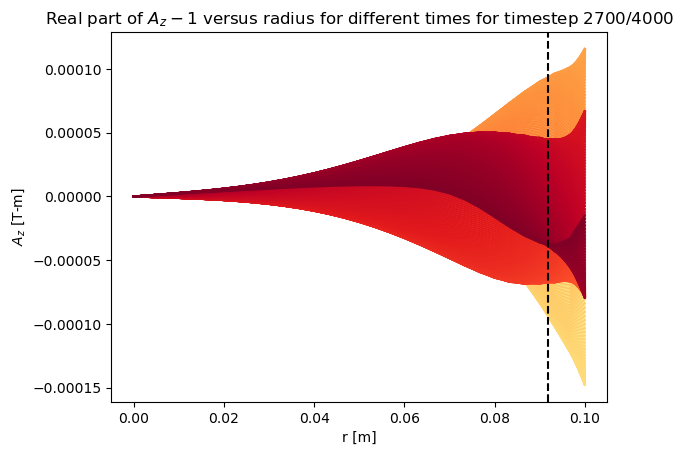

In [23]:
# test the area with saving times every so often 
from matplotlib import cm
#cmap = cm.get_cmap('inferno')
#cmap = cm.get_cmap('Reds')
cmap = cm.get_cmap('YlOrRd')
#cmap = cm.get_cmap('autumn')
m = -1
im = np.where(m_array == m)[0][0]
print(im)
print(A_z_hold_out[im].shape[0])
toplot='r'
range_to_plot = 540 #540 #A_z_hold_out[im].shape[0]
if toplot == 'r':
    for i in range(range_to_plot):
        cmap_color = cmap(i/range_to_plot)
        plt.plot(r_array, np.real(A_z_hold_out[im][i, :]), color=cmap_color)#, alpha = (1 - i/255))
    plt.title(f'Real part of $A_z{m}$ versus radius for different times for timestep {range_to_plot*timestep_save_interval}/{nt}')
    
if toplot == 'i':
    for i in range(range_to_plot):
        cmap_color = cmap(i/range_to_plot)
        plt.plot(r_array, np.imag(A_z_hold_out[im][i, :]), color=cmap_color)
    plt.title(f'Imaginary part of $A_z{m}$ versus radius for different times for timestep {range_to_plot*timestep_save_interval}/{nt}')
    
plt.xlabel('r [m]')
plt.ylabel(r'$A_z$ [T-m]')

d_skin = np.sqrt(2*eta/(mu0*w_RMF))

plt.axvline(x=(R-d_skin), color='black', linestyle='--')

In [24]:
print(A_z_hold_out[1][58, :])

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.-0.j]


3


(-0.04, 0.04)

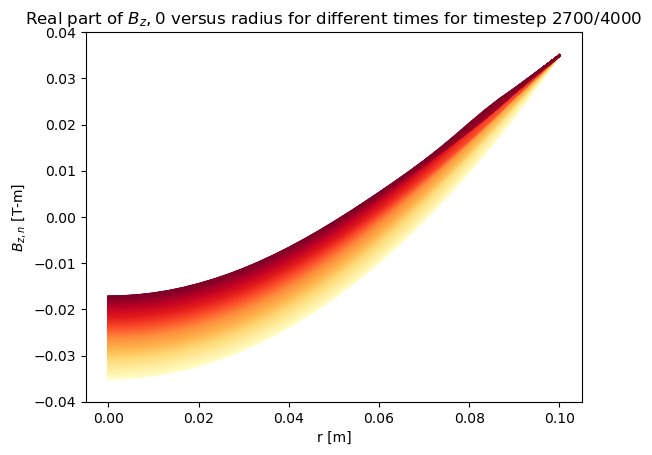

In [25]:
n = 0
i_n = np.where(n_array == n)[0][0]
print(i_n)
#range_to_plot = 530 #B_z_hold_out[i_n].shape[0] # 1145# B_z_hold_out[i_n].shape[0]
for i in range(range_to_plot):#B_z_hold_out[i_n].shape[0]):
    cmap_color = cmap(i/range_to_plot)
    plt.plot(r_array, np.real(B_z_hold_out[i_n][i, :]), color=cmap_color)#, alpha = (i/255))
plt.title(f'Real part of $B_z,{n}$ versus radius for different times for timestep {range_to_plot*timestep_save_interval}/{nt}')
plt.xlabel('r [m]') 
plt.ylabel(r'$B_{z, n}$ [T-m]')
plt.ylim(-0.04, .04)

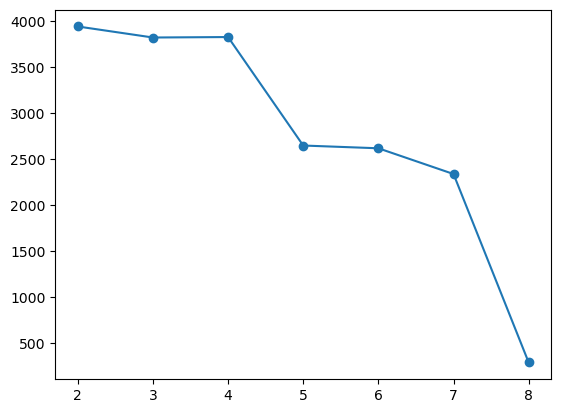

In [26]:
# This area is to record the spectral response with one full predictor-corrector iteration. 
nmode_array = np.array([2, 3, 4, 5, 6, 7, 8])
n_timesteps_to_last_nonNAN = np.array([3945, 3825, 3830, 2650, 2620, 2340, 290])
n_tsteps = np.array([4000, 4000, 4000])
dt_recording = np.array([3e-9, 3e-9, 3e-9])

plt.plot(nmode_array, n_timesteps_to_last_nonNAN)
plt.scatter(nmode_array, n_timesteps_to_last_nonNAN)

In [27]:
# build total A_z = sum_m(A_m): 

A_Z_TOTAL = np.zeros((tnew.shape[0], nr, nphi), dtype ='complex_')
print(A_Z_TOTAL.shape)
print(A_z_hold_out[0].shape)
for it in range(tnew.shape[0]):
    print('Percent complete: ', 100*it/tnew.shape[0])
    for ir in range(r_array.shape[0]-1):
        r = dr*ir
        for iphi in range(phi_array.shape[0]):
            phi = iphi*dphi
            for im in range(m_array.shape[0]):
                m = m_array[im]
                A_Z_TOTAL[it, ir, iphi] = A_Z_TOTAL[it, ir, iphi] + \
                                          A_z_hold_out[im][it, ir]*np.exp(1j*m*phi)

(800, 31, 30)
(800, 31)
Percent complete:  0.0
Percent complete:  0.125
Percent complete:  0.25
Percent complete:  0.375
Percent complete:  0.5
Percent complete:  0.625
Percent complete:  0.75
Percent complete:  0.875
Percent complete:  1.0
Percent complete:  1.125
Percent complete:  1.25
Percent complete:  1.375
Percent complete:  1.5
Percent complete:  1.625
Percent complete:  1.75
Percent complete:  1.875
Percent complete:  2.0
Percent complete:  2.125
Percent complete:  2.25
Percent complete:  2.375
Percent complete:  2.5
Percent complete:  2.625
Percent complete:  2.75
Percent complete:  2.875
Percent complete:  3.0
Percent complete:  3.125
Percent complete:  3.25
Percent complete:  3.375
Percent complete:  3.5
Percent complete:  3.625
Percent complete:  3.75
Percent complete:  3.875
Percent complete:  4.0
Percent complete:  4.125
Percent complete:  4.25
Percent complete:  4.375
Percent complete:  4.5
Percent complete:  4.625
Percent complete:  4.75
Percent complete:  4.875
Percen

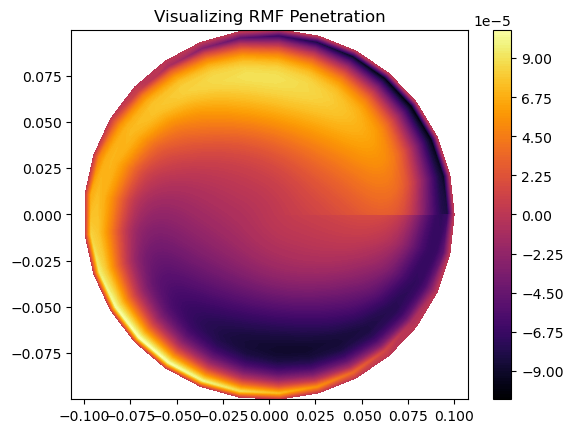

In [28]:
# plot theta 
A_Z_TOTAL_FINAL = A_Z_TOTAL[range_to_plot-10, :, :]# A_Z_TOTAL[1144, :, :]#A_Z_TOTAL_FINAL = A_Z_TOTAL[-1, :, :]
rmesh, phimesh = np.meshgrid(r_array, phi_array)

X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)
#print(A_Z_TOTAL_FINAL)
plt.contourf(X, Y, np.real(A_Z_TOTAL_FINAL), levels=200, cmap='inferno')
#plt.contour(X, Y, np.real(A_Z_TOTAL_FINAL), levels=20, color='k')
plt.title('Visualizing RMF Penetration')
plt.axis('equal')
plt.colorbar()
plt.show()

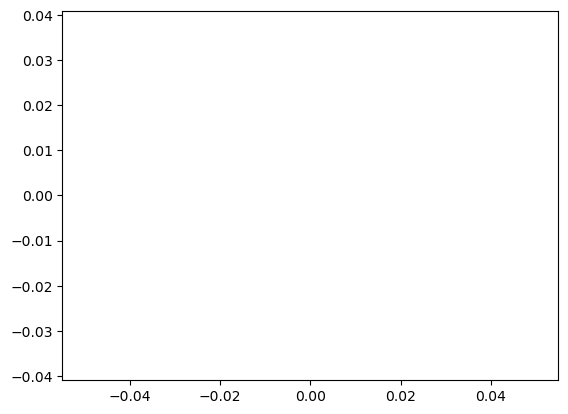

In [29]:
from matplotlib.animation import FuncAnimation 
fig, ax = plt.subplots()
plt.axis('equal')
rmesh, phimesh = np.meshgrid(r_array, phi_array)
X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)
minimal_value = np.min(A_Z_TOTAL)
maximal_value = np.max(A_Z_TOTAL)
def animate(frame_num):
    ax.clear()
    A_Z_TOTAL_FRAME = A_Z_TOTAL[frame_num*10, :, :]
    ax.contourf(X, Y, np.real(A_Z_TOTAL_FRAME), levels=200, cmap='inferno')#, vmin=minimal_value,vmax=maximal_value)
    #ax.colorbar()
anim = FuncAnimation(fig, animate, frames=nt, interval=5)
plt.show()

In [30]:
# build total B_z = sum_m(A_m): 

B_Z_TOTAL = np.zeros((tnew.shape[0], nr, nphi), dtype ='complex_')
for it in range(tnew.shape[0]):
    print('Percent complete: ', 100*it/tnew.shape[0])
    for ir in range(r_array.shape[0]-1):
        r = dr*ir
        for iphi in range(phi_array.shape[0]):
            phi = iphi*dphi
            for i_n in range(n_array.shape[0]):
                n = n_array[i_n]
#                 if n != 0: # TODO: REMOVE THIS!!
                B_Z_TOTAL[it, ir, iphi] = B_Z_TOTAL[it, ir, iphi] + \
                                          B_z_hold_out[i_n][it, ir]*np.exp(1j*n*phi)

Percent complete:  0.0
Percent complete:  0.125
Percent complete:  0.25
Percent complete:  0.375
Percent complete:  0.5
Percent complete:  0.625
Percent complete:  0.75
Percent complete:  0.875
Percent complete:  1.0
Percent complete:  1.125
Percent complete:  1.25
Percent complete:  1.375
Percent complete:  1.5
Percent complete:  1.625
Percent complete:  1.75
Percent complete:  1.875
Percent complete:  2.0
Percent complete:  2.125
Percent complete:  2.25
Percent complete:  2.375
Percent complete:  2.5
Percent complete:  2.625
Percent complete:  2.75
Percent complete:  2.875
Percent complete:  3.0
Percent complete:  3.125
Percent complete:  3.25
Percent complete:  3.375
Percent complete:  3.5
Percent complete:  3.625
Percent complete:  3.75
Percent complete:  3.875
Percent complete:  4.0
Percent complete:  4.125
Percent complete:  4.25
Percent complete:  4.375
Percent complete:  4.5
Percent complete:  4.625
Percent complete:  4.75
Percent complete:  4.875
Percent complete:  5.0
Percent

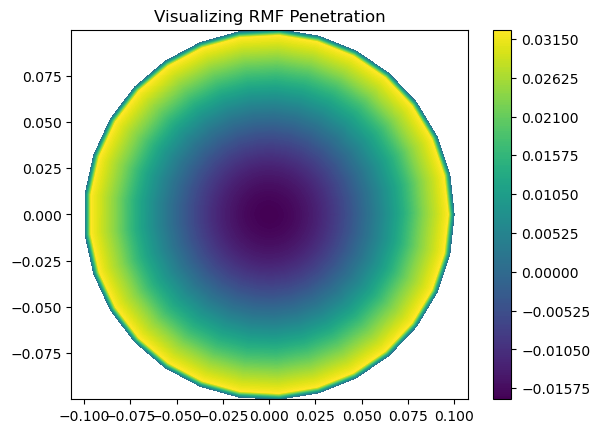

In [31]:
# plot theta 
B_Z_TOTAL_FINAL = B_Z_TOTAL[range_to_plot-1, :, :]# B_Z_TOTAL_FINAL = B_Z_TOTAL[-1, :, :]
rmesh, phimesh = np.meshgrid(r_array, phi_array)

X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)

plt.contourf(X, Y, np.real(B_Z_TOTAL_FINAL), levels=200, cmap='viridis')
plt.title('Visualizing RMF Penetration')
plt.axis('equal')
plt.colorbar()
plt.show()

c:\Users\jacob\anaconda3\lib\site-packages\matplotlib\animation.py:880: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


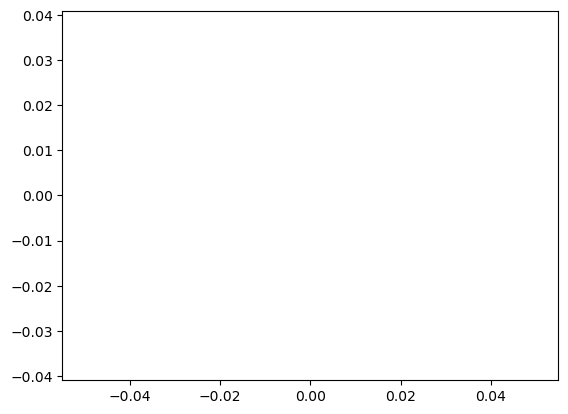

In [32]:
from matplotlib.animation import FuncAnimation 
fig, ax = plt.subplots()
plt.axis('equal')
rmesh, phimesh = np.meshgrid(r_array, phi_array)
X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)
minimal_value = np.min(B_Z_TOTAL)
maximal_value = np.max(B_Z_TOTAL)
def animate(frame_num):
    ax.clear()
    B_Z_TOTAL_FRAME = B_Z_TOTAL[frame_num*10, :, :]
    ax.contourf(X, Y, np.real(B_Z_TOTAL_FRAME), levels=200, cmap='viridis')#, vmin=minimal_value,vmax=maximal_value)
    #ax.colorbar()
anim = FuncAnimation(fig, animate, frames=nt, interval=5)
plt.show()

In [33]:
# build J_r
J_rm_hold = []
for im in range(m_array.shape[0]):
    m = m_array[im]
    J_rm = np.zeros((tnew.shape[0], nr), dtype ='complex_')  # create J_r time evolution holder 
    J_rm_hold.append(J_rm)  # append initial conditions of J_rm to the list

# build J_phi
J_phim_hold = []
for im in range(m_array.shape[0]):
    m = m_array[im]
    J_phim = np.zeros((tnew.shape[0], nr), dtype ='complex_')  # create J_r time evolution holder 
    J_phim_hold.append(J_phim)  # append initial conditions of J_rm to the list

# build J_z
J_zm_hold = []
for im in range(m_array.shape[0]):
    m = m_array[im]
    J_zm = np.zeros((tnew.shape[0], nr), dtype ='complex_')  # create J_r time evolution holder 
    J_zm_hold.append(J_zm)  # append initial conditions of J_rm to the list

# calculate J_r
for it in range(tnew.shape[0]):
    for im in range(m_array.shape[0]):
        m = m_array[im]
        J_rm = J_rm_hold[im]
        for ir in range(1, r_array.shape[0]-1):
            r = r_array[ir]
            Bz_mr = B_z_hold_out[im][it, ir]
            J_rm[it, ir] = 1j*m/(mu0*r) * Bz_mr
        J_rm_hold[im] = J_rm

# calculate J_phi
for it in range(tnew.shape[0]):
    for im in range(m_array.shape[0]):
        m = m_array[im]
        J_phim = J_phim_hold[im]
        for ir in range(1, r_array.shape[0]-1):
            r = r_array[ir]
            Bz_mrp = B_z_hold_out[im][it, ir+1]
            Bz_mrminus = B_z_hold_out[im][it, ir-1]
            J_phim[it, ir] = -(1/mu0) * (Bz_mrp - Bz_mrminus)/(2*dr)
        J_phim_hold[im] = J_phim

# calculate J_z
for it in range(tnew.shape[0]):
    for im in range(m_array.shape[0]):
        m = m_array[im]
        J_zm = J_zm_hold[im]
        for ir in range(1, r_array.shape[0]-1):
            r = r_array[ir]
            Az_mp = A_z_hold_out[im][it, ir+1]
            Bz_mminus = A_z_hold_out[im][it, ir-1]
            Az_m = A_z_hold_out[im][it, ir]
            rp1_2 = r + dr/2
            rm_1_2 = r - dr/2
            dAdr_p = rp1_2*(Az_mp - Az_m)/(dr)
            dAdr_m = rm_1_2*(Az_mp - Az_m)/(dr)
            J_zm[it, ir] = (1/mu0) * (1/r) * ((1/dr)*(dAdr_p - dAdr_m)) + (1/mu0)*m**2/r**2 * Az_m
        J_zm_hold[im] = J_zm





In [34]:
# build the current 
# build total J_R = sum_m(A_m): 

J_R_TOTAL = np.zeros((tnew.shape[0], nr, nphi), dtype ='complex_')
print(J_R_TOTAL.shape)
print(A_z_hold_out[0].shape)
for it in range(tnew.shape[0]):
    print('Percent complete: ', 100*it/tnew.shape[0])
    for ir in range(r_array.shape[0]-1):
        r = dr*ir
        for iphi in range(phi_array.shape[0]):
            phi = iphi*dphi
            for im in range(m_array.shape[0]):
                m = m_array[im]
                J_R_TOTAL[it, ir, iphi] = J_R_TOTAL[it, ir, iphi] + \
                                          J_rm_hold[im][it, ir]*np.exp(1j*m*phi)

(800, 31, 30)
(800, 31)
Percent complete:  0.0
Percent complete:  0.125
Percent complete:  0.25
Percent complete:  0.375
Percent complete:  0.5
Percent complete:  0.625
Percent complete:  0.75
Percent complete:  0.875
Percent complete:  1.0
Percent complete:  1.125
Percent complete:  1.25
Percent complete:  1.375
Percent complete:  1.5
Percent complete:  1.625
Percent complete:  1.75
Percent complete:  1.875
Percent complete:  2.0
Percent complete:  2.125
Percent complete:  2.25
Percent complete:  2.375
Percent complete:  2.5
Percent complete:  2.625
Percent complete:  2.75
Percent complete:  2.875
Percent complete:  3.0
Percent complete:  3.125
Percent complete:  3.25
Percent complete:  3.375
Percent complete:  3.5
Percent complete:  3.625
Percent complete:  3.75
Percent complete:  3.875
Percent complete:  4.0
Percent complete:  4.125
Percent complete:  4.25
Percent complete:  4.375
Percent complete:  4.5
Percent complete:  4.625
Percent complete:  4.75
Percent complete:  4.875
Percen

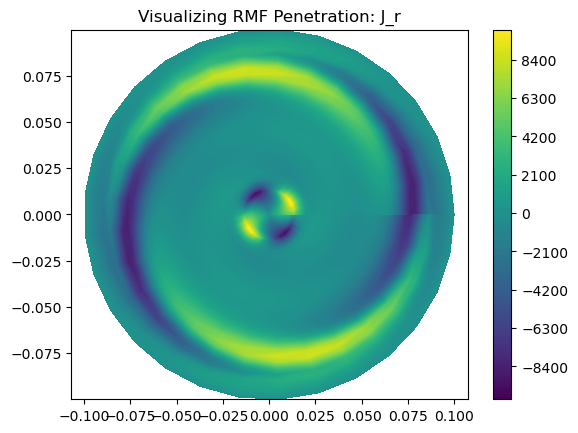

In [36]:
# plot theta 
J_R_TOTAL_FINAL = J_R_TOTAL[range_to_plot-1, :, :]# B_Z_TOTAL_FINAL = B_Z_TOTAL[-1, :, :]
rmesh, phimesh = np.meshgrid(r_array, phi_array)

X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)

plt.contourf(X, Y, np.real(J_R_TOTAL_FINAL), levels=200, cmap='viridis')
plt.title('Visualizing RMF Penetration: J_r')
plt.axis('equal')
plt.colorbar()
plt.show()

In [37]:
# build the phi current 
# build total J_R = sum_m(A_m): 

J_PHI_TOTAL = np.zeros((tnew.shape[0], nr, nphi), dtype ='complex_')
print(J_PHI_TOTAL.shape)
print(A_z_hold_out[0].shape)
for it in range(tnew.shape[0]):
    print('Percent complete: ', 100*it/tnew.shape[0])
    for ir in range(r_array.shape[0]-1):
        r = dr*ir
        for iphi in range(phi_array.shape[0]):
            phi = iphi*dphi
            for im in range(m_array.shape[0]):
                m = m_array[im]
                J_PHI_TOTAL[it, ir, iphi] = J_PHI_TOTAL[it, ir, iphi] + \
                                          J_phim_hold[im][it, ir]*np.exp(1j*m*phi)

(800, 31, 30)
(800, 31)
Percent complete:  0.0
Percent complete:  0.125
Percent complete:  0.25
Percent complete:  0.375
Percent complete:  0.5
Percent complete:  0.625
Percent complete:  0.75
Percent complete:  0.875
Percent complete:  1.0
Percent complete:  1.125
Percent complete:  1.25
Percent complete:  1.375
Percent complete:  1.5
Percent complete:  1.625
Percent complete:  1.75
Percent complete:  1.875
Percent complete:  2.0
Percent complete:  2.125
Percent complete:  2.25
Percent complete:  2.375
Percent complete:  2.5
Percent complete:  2.625
Percent complete:  2.75
Percent complete:  2.875
Percent complete:  3.0
Percent complete:  3.125
Percent complete:  3.25
Percent complete:  3.375
Percent complete:  3.5
Percent complete:  3.625
Percent complete:  3.75
Percent complete:  3.875
Percent complete:  4.0
Percent complete:  4.125
Percent complete:  4.25
Percent complete:  4.375
Percent complete:  4.5
Percent complete:  4.625
Percent complete:  4.75
Percent complete:  4.875
Percen

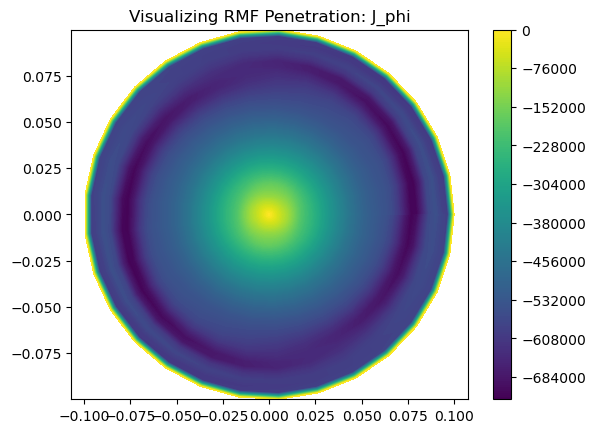

In [38]:
# plot theta 
J_PHI_TOTAL_FINAL = J_PHI_TOTAL[range_to_plot-1, :, :]# B_Z_TOTAL_FINAL = B_Z_TOTAL[-1, :, :]
rmesh, phimesh = np.meshgrid(r_array, phi_array)

X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)

plt.contourf(X, Y, np.real(J_PHI_TOTAL_FINAL), levels=200, cmap='viridis')
plt.title('Visualizing RMF Penetration: J_phi')
plt.axis('equal')
plt.colorbar()
plt.show()

In [39]:
# build the z current 
# build total J_z = sum_m(A_m): 

J_Z_TOTAL = np.zeros((tnew.shape[0], nr, nphi), dtype ='complex_')
print(J_Z_TOTAL.shape)
print(A_z_hold_out[0].shape)
for it in range(tnew.shape[0]):
    print('Percent complete: ', 100*it/tnew.shape[0])
    for ir in range(r_array.shape[0]-1):
        r = dr*ir
        for iphi in range(phi_array.shape[0]):
            phi = iphi*dphi
            for im in range(m_array.shape[0]):
                m = m_array[im]
                J_Z_TOTAL[it, ir, iphi] = J_Z_TOTAL[it, ir, iphi] + \
                                          J_zm_hold[im][it, ir]*np.exp(1j*m*phi)

(800, 31, 30)
(800, 31)
Percent complete:  0.0
Percent complete:  0.125
Percent complete:  0.25
Percent complete:  0.375
Percent complete:  0.5
Percent complete:  0.625
Percent complete:  0.75
Percent complete:  0.875
Percent complete:  1.0
Percent complete:  1.125
Percent complete:  1.25
Percent complete:  1.375
Percent complete:  1.5
Percent complete:  1.625
Percent complete:  1.75
Percent complete:  1.875
Percent complete:  2.0
Percent complete:  2.125
Percent complete:  2.25
Percent complete:  2.375
Percent complete:  2.5
Percent complete:  2.625
Percent complete:  2.75
Percent complete:  2.875
Percent complete:  3.0
Percent complete:  3.125
Percent complete:  3.25
Percent complete:  3.375
Percent complete:  3.5
Percent complete:  3.625
Percent complete:  3.75
Percent complete:  3.875
Percent complete:  4.0
Percent complete:  4.125
Percent complete:  4.25
Percent complete:  4.375
Percent complete:  4.5
Percent complete:  4.625
Percent complete:  4.75
Percent complete:  4.875
Percen

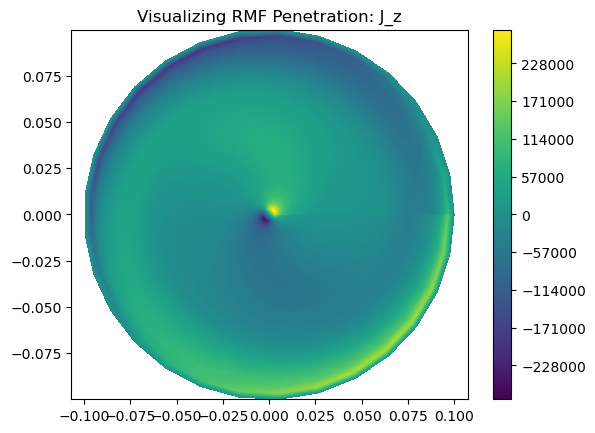

In [40]:
# plot
J_Z_TOTAL_FINAL = J_Z_TOTAL[range_to_plot-1, :, :]# B_Z_TOTAL_FINAL = B_Z_TOTAL[-1, :, :]
rmesh, phimesh = np.meshgrid(r_array, phi_array)

X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)

plt.contourf(X, Y, np.real(J_Z_TOTAL_FINAL), levels=200, cmap='viridis')
plt.title('Visualizing RMF Penetration: J_z')
plt.axis('equal')
plt.colorbar()
plt.show()

(31, 9)


<IPython.core.display.Javascript object>


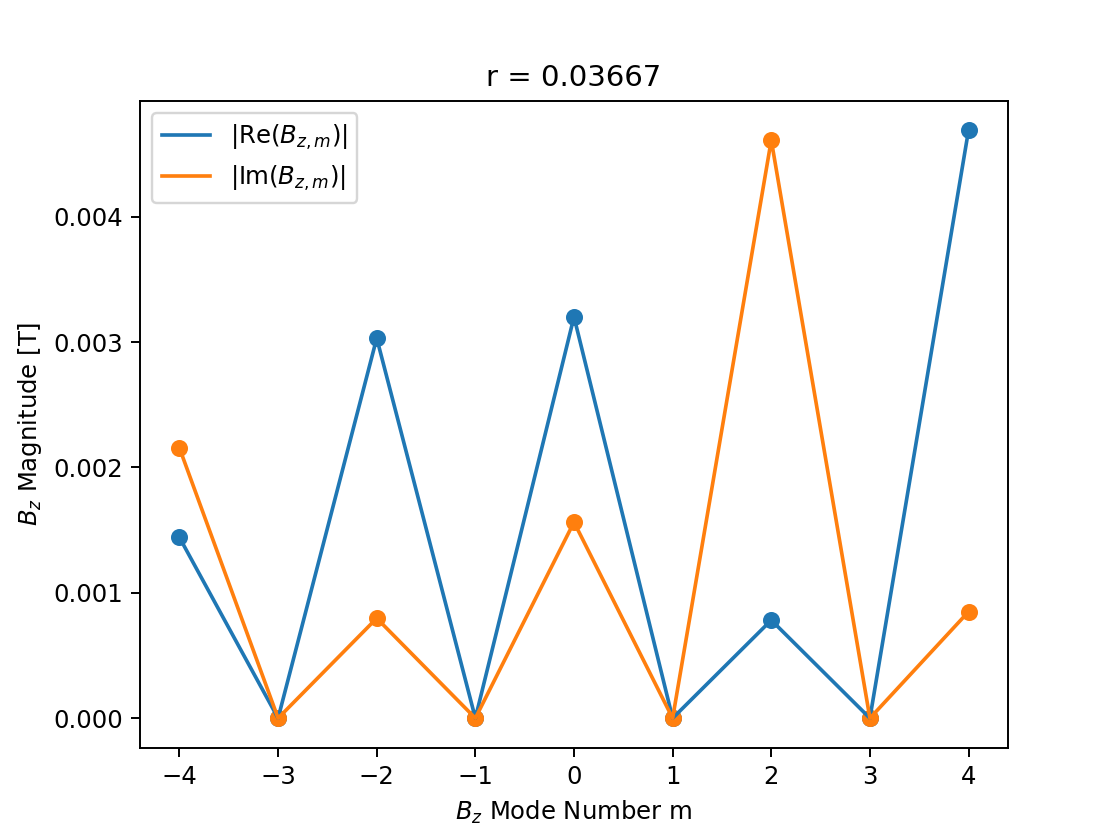

Text(0.5, 1.0, 'r = 0.03667')

In [29]:
# ---------------------------------------------
# Mode testing area 
# ---------------------------------------------

time_index = range_to_plot #1145#1708#-1  # the time index to grab the modes to plot. Note default is -1 
time_index -= 1 # For some reason, the time index used for the above plots is 1 ahead of the one here
r_to_plot = 0.0366

mode_mag_holder = np.zeros((r_array.shape[0], n_array.shape[0]), dtype='complex_')
for i_n in range(n_array.shape[0]):
    n = n_array[i_n]
    B_zn_r_last_time = B_z_hold_out[i_n][time_index, :]
    mode_mag_holder[:, i_n] = B_zn_r_last_time
print(mode_mag_holder.shape)


if (r_to_plot > R):
    raise ValueError(f'r_to_plot = {r_to_plot} > R = {R}')
ir = np.argmin(np.abs(r_array - r_to_plot))
plt.plot(n_array, abs(np.real(mode_mag_holder[ir, :])), label=r'|Re($B_{z,m}$)|')
plt.plot(n_array, abs(np.imag(mode_mag_holder[ir, :])), label=r'|Im($B_{z,m}$)|')
plt.scatter(n_array, abs(np.real(mode_mag_holder[ir, :])))
plt.scatter(n_array, abs(np.imag(mode_mag_holder[ir, :])))
plt.xlabel(r'$B_z$ Mode Number m')
plt.ylabel(r'$B_z$ Magnitude [T]')
plt.legend()
plt.title(f'r = {round(r_array[ir], 5)}')


<IPython.core.display.Javascript object>


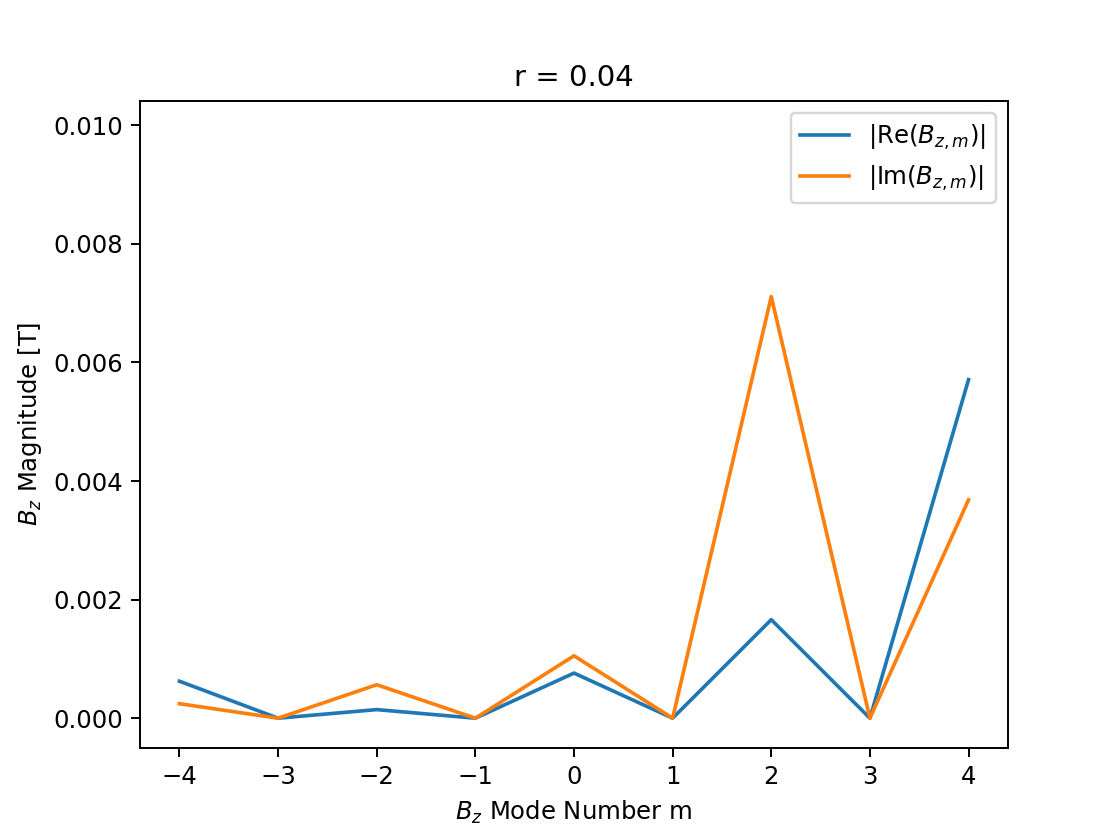

interactive(children=(FloatSlider(value=0.04, description='r', max=0.12, min=-0.04), Output()), _dom_classes=(…

In [30]:
# Same as above cell but with a slider widget to show the change in radius effect
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

# x = np.linspace(0, 2 * np.pi)
r_to_plot = 0.03226
if (r_to_plot > R):
    raise ValueError(f'r_to_plot = {r_to_plot} > R = {R}')
    
ir = np.argmin(np.abs(r_array - r_to_plot))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line1, = ax.plot(n_array, abs(np.real(mode_mag_holder[ir, :])), label=r'|Re($B_{z,m}$)|')
line2, = ax.plot(n_array, abs(np.imag(mode_mag_holder[ir, :])), label=r'|Im($B_{z,m}$)|')

def update(r = 0.04):
    ir = np.argmin(np.abs(r_array - r))
    line1.set_ydata(abs(np.real(mode_mag_holder[ir, :])))
    line2.set_ydata(abs(np.imag(mode_mag_holder[ir, :])))
    plt.xlabel(r'$B_z$ Mode Number m')
    plt.ylabel(r'$B_z$ Magnitude [T]')
    plt.title(f'r = {r}')
    plt.legend()
    fig.canvas.draw_idle()
    

interact(update);

<IPython.core.display.Javascript object>


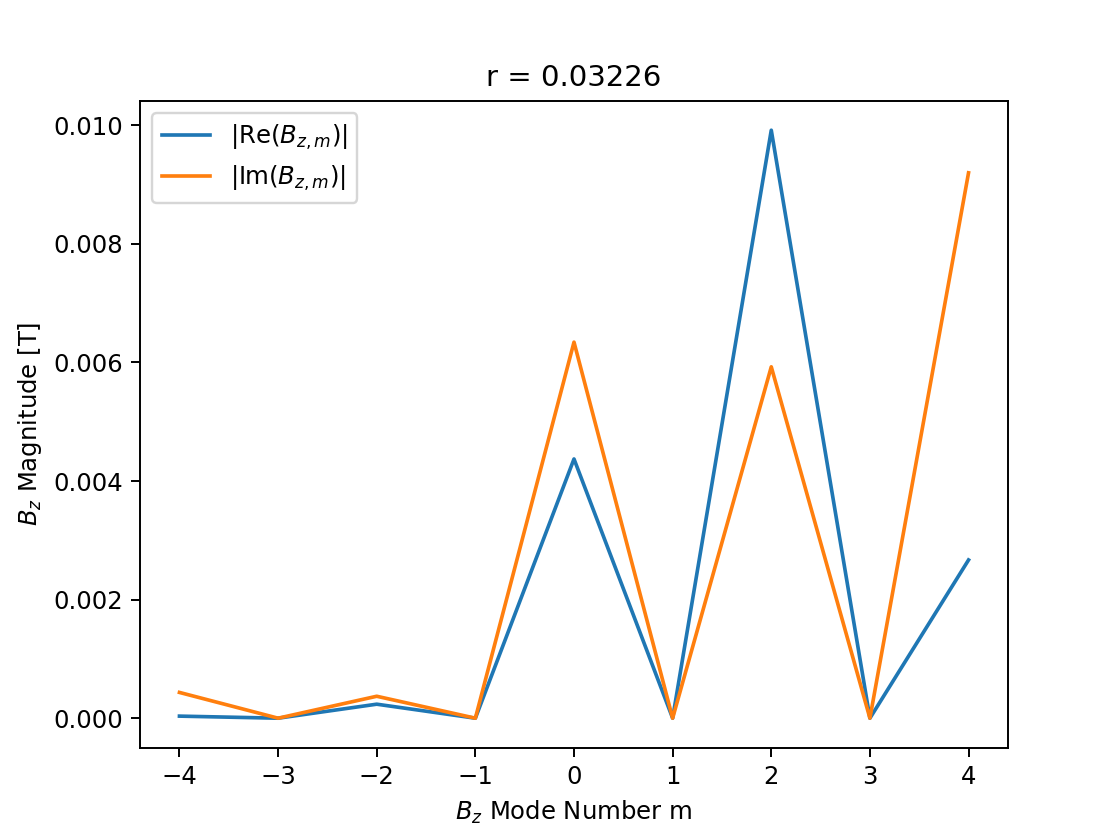

interactive(children=(FloatSlider(value=0.03226, description='r', max=0.1, min=0.0032258064516129032, readout_…

<function __main__.update(r=0.04)>

In [31]:
ir = np.argmin(np.abs(r_array - r_to_plot))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line1, = ax.plot(n_array, abs(np.real(mode_mag_holder[ir, :])), label=r'|Re($B_{z,m}$)|')
line2, = ax.plot(n_array, abs(np.imag(mode_mag_holder[ir, :])), label=r'|Im($B_{z,m}$)|')
interact(update, r = widgets.FloatSlider(value=0.03226,
                                               min=dr,
                                               max=R,
                                               step=dr,
                                               readout_format='.4f'))

In [32]:
#---------------------------------------------------------------
# Particle Orbit testing area

def A_phi(x, y, z, t):
    K = 0.08/2  # [Tesla]  TODO: 0.08
    rs = 0.05  # [m]
    r = np.sqrt(x**2 + y**2)
    zs = 0.3  # [m]
    return -2*K*(rs**2/2)*(r/rs**2)*(1 - r**2/(2*rs**2) - z**2/zs**2)

def Lorentz(r_v, t):
    r = r_v[0:3]
    v = r_v[3:]
    E = Ef(r[0], r[1], r[2], t)
    B = Bf(r[0], r[1], r[2], t)
    a = q*(E + np.cross(v, B))/m
    return np.append(v, a)

def plotcircle(r, thetav):
    x = r*np.cos(thetav)
    y = r*np.sin(thetav)
    return x, y

#print(B_Z_TOTAL.shape)

def get_Bz(xp, yp, r_array, phi_array, i_t):
    """
    Interpolates the Bz field from the mesh onto the particle 
    """
    rp = np.sqrt(xp**2 + yp**2)
    phip = np.arctan2(yp, xp)
    i_r = np.argmin(np.abs(r_array - rp))
    i_phi = np.argmin(np.abs(phi_array - phip))
    if r_array[i_r] < rp:
        i_r2 = i_r + 1
        i_r1 = i_r
    elif r_array[i_r] >= rp:
        i_r2 = i_r
        i_r1 = i_r - 1
        
    if phi_array[i_phi] < phip:
        i_phi2 = i_phi + 1
        i_phi1 = i_phi
    elif phi_array[i_phi] >= phip:
        i_phi2 = i_phi
        i_phi1 = i_phi - 1
        
    R1 = r_array[i_r1]
    R2 = r_array[i_r2]
    
    P1 = phi_array[i_phi1]
    P2 = phi_array[i_phi2]
    
    # find fractions to weight the mesh nodes with for interpolating to the particle 
    total_area = np.pi*(R2**2 - R1**2) * (P2 - P1)/(2*np.pi)
    area1 = np.pi*(R2**2 - rp**2) * (P2 - phip)/(2*np.pi)
    area2 = np.pi*(R2**2 - rp**2) * (phip - P1)/(2*np.pi)
    area3 = np.pi*(rp**2 - R1**2) * (P2 - phip)/(2*np.pi)
    area4 = np.pi*(rp**2 - R1**2) * (phip - P1)/(2*np.pi)
    
    f1 = area1 / total_area
    f2 = area2 / total_area
    f3 = area3 / total_area
    f4 = area4 / total_area
    
    #print(f'i_r2: {i_r2}')
    #print(f'i_phi2: {i_phi2}')
    #print(f'i_r1: {i_r1}')
    #print(f'i_phi1: {i_phi1}')
    #print(f'Bz_a: {np.real(B_Z_TOTAL[i_t, i_r2, i_phi2])}')
    Bz_a = np.real(B_Z_TOTAL[i_t, i_r2, i_phi2]).item()
    Bz_b = np.real(B_Z_TOTAL[i_t, i_r2, i_phi1]).item()
    Bz_c = np.real(B_Z_TOTAL[i_t, i_r1, i_phi2]).item()
    Bz_d = np.real(B_Z_TOTAL[i_t, i_r1, i_phi1]).item()
    #print(f'Bz_d[0][0] {Bz_d}')
    # return the interpolated field for the particle 
    return np.array([0, 0, Bz_a*f4 + Bz_b*f3 + Bz_c*f2 + Bz_d*f1])
    
    
def get_Az(xp, yp, r_array, phi_array, i_t):
    """
    Interpolates the Az field from the mesh onto the particle 
    """
    rp = np.sqrt(xp**2 + yp**2)
    phip = np.arctan2(yp, xp)
    i_r = np.argmin(np.abs(r_array - rp))
    i_phi = np.argmin(np.abs(phi_array - phip))
    if r_array[i_r] < rp:
        i_r2 = i_r + 1
        i_r1 = i_r
    elif r_array[i_r] >= rp:
        i_r2 = i_r
        i_r1 = i_r - 1
        
    if phi_array[i_phi] < phip:
        i_phi2 = i_phi + 1
        i_phi1 = i_phi
    elif phi_array[i_phi] >= phip:
        i_phi2 = i_phi
        i_phi1 = i_phi - 1
        
    R1 = r_array[i_r1]
    R2 = r_array[i_r2]
    
    P1 = phi_array[i_phi1]
    P2 = phi_array[i_phi2]
    
    # find fractions to weight the mesh nodes with for interpolating to the particle 
    total_area = np.pi*(R2**2 - R1**2) * (P2 - P1)/(2*np.pi)
    area1 = np.pi*(R2**2 - rp**2) * (P2 - phip)/(2*np.pi)
    area2 = np.pi*(R2**2 - rp**2) * (phip - P1)/(2*np.pi)
    area3 = np.pi*(rp**2 - R1**2) * (P2 - phip)/(2*np.pi)
    area4 = np.pi*(rp**2 - R1**2) * (phip - P1)/(2*np.pi)
    
    f1 = area1 / total_area
    f2 = area2 / total_area
    f3 = area3 / total_area
    f4 = area4 / total_area
    
    Az_a = np.real(A_Z_TOTAL[i_t, i_r2, i_phi2]) 
    Az_b = np.real(A_Z_TOTAL[i_t, i_r2, i_phi1]) 
    Az_c = np.real(A_Z_TOTAL[i_t, i_r1, i_phi2]) 
    Az_d = np.real(A_Z_TOTAL[i_t, i_r1, i_phi1]) 
    
    # calculate the curl 
    alpha = Az_a*((rp - R1)/(R2 - R1)) + Az_c*((R2-rp)/(R2 - R1))
    beta =  Az_b*((rp - R1)/(R2 - R1)) + Az_d*((R2-rp)/(R2 - R1))
    
    dAzdphi = (1/rp)*(alpha - beta)/(P2 - P1)
    
    delta = Az_a*((phip - P1)/(P2 - P1)) + Az_b*((P2-phip)/(P2 - P1))
    gamma = Az_c*((phip - P1)/(P2 - P1)) + Az_d*((P2-phip)/(P2 - P1))
    
    dAzdr = (delta - gamma) / (R2 - R1)
    
    rho_hat = np.array([np.cos(phip), np.sin(phip), 0])
    phi_hat = np.array([-np.sin(phip), np.cos(phip), 0])
    
    # return the curl in cartesian coordinates 
    return dAzdphi*rho_hat - dAzdr*phi_hat 


def Ef(x, y, z, t):
    """
    Defines the electric field externally applied. This is user defined and should return a vector.
    :param x: x cord.
    :param y: y cord.
    :param z: z cord.
    :param t: time
    :return: vector containing Ex, Ey, Ez
    """
    dx = dr  # arbitrary choice, but chose this so mesh accuracy is overestimated
    dy = dr
    
    # begin calculating the curl of B at the particle location 
    Bf_minus_dx = Bf(x - dx, y, z, t)
    Bf_plus_dx = Bf(x + dx, y, z, t)
    
    Bf_minus_dy = Bf(x, y - dy, z, t)
    Bf_plus_dy = Bf(x, y + dy , z, t)
    
    Bz_pdx = Bf_plus_dx[2]  # get z-componant of this vector 
    Bz_mdx = Bf_minus_dx[2]  
    
    Bz_pdy = Bf_plus_dy[2]
    Bz_mdy = Bf_minus_dy[2]
    
    By_pdx = Bf_plus_dx[1]  # get y-componant of this vector 
    By_mdx = Bf_minus_dx[1]
    
    Bx_pdy = Bf_plus_dy[0] # get the x-componant of this vector 
    Bx_mdy = Bf_minus_dy[0]    
    
    Bcurl_x = (Bz_pdy - Bz_mdy)/(2*dy)
    Bcurl_y = -(Bz_pdx - Bz_mdx)/(2*dx)
    Bcurl_z = (By_pdx - By_mdx)/(2*dx) - (Bx_pdy - Bx_mdy)/(2*dy)
    
    B_curl = np.array([Bcurl_x, Bcurl_y, Bcurl_z])
    #print(f'B_curl: {B_curl}')
    J = (1/mu0)*B_curl
    B = Bf(x, y, z, t)
    
    E = eta*J + (1/(ne*e))*np.cross(J, B)
    return E


def Bf(x, y, z, t):
    """
    Defines the electric field externally applied. This is user defined and should return a vector.
    :param x: x cord.
    :param y: y cord.
    :param z: z cord.
    :param t: time. Must be from t_array. 
    :return: vector containing Ex, Ey, Ez
    """
#     K = 0.08/2  # [Tesla]
#     rs = 0.07  # [m]  0.05 TODO: ORGINAL
#     zs = 0.3  # [m]
#     B0 = -350e-4
#     r = np.sqrt(x**2 + y**2)
#     Bz = B0*(1 - (r/rs)**2)
#     Br = B0*r*z/zs**2
#     phi = np.arctan2(y, x)
#     Bx = Br*np.cos(phi)
#     By = Br*np.sin(phi)
    i_t = np.argmin(np.abs(tnew - t))
    #print(f'i_t: {i_t}')
    Bz = get_Bz(x, y, r_array, phi_array, i_t)
    #print(f'Bz shape: {Bz}')
    curlAz = get_Az(x, y, r_array, phi_array, i_t)
    #print(f'curlAz shape: {curlAz}')
    Btot = Bz + curlAz
    #print(Btot)
    return Btot

In [40]:
# print(np.real(B_Z_TOTAL[0, :, :]))
[0.0, -0.8399999999999992, 0.0]*0.1

TypeError: can't multiply sequence by non-int of type 'float'

In [33]:
# particle properties 
# Cell to enter all physical constants, as well as simulation parameters. 
q = 1.60218e-19 # fundamental charge
m = 1.6735575e-27  # mass of particle
kbT = 5 # [eV]
kbT = kbT * 1.60218e-19 # convert to J
vth = np.sqrt(2*kbT/m)  # thermal velocity in [m/s]
r_init = [0.06, 0, 0] #[0.01, 0, 0] #[0.07, 0, 0]
v_init = [-vth/np.sqrt(2), vth/np.sqrt(2), 0]
# r_init = [0.01, 0, 0]   Good ones to use
# v_init = [-vth/2, vth/2, 0]
IC = np.append(np.array(r_init), np.array(v_init))
rs = 0.07 # [m]
# dt = 1e-8 # time delta in seconds
# sim_time = 55e-7  # number of seconds we should be simulating for

# time_vec = np.arange(0, sim_time, dt)
time_vec = tnew[:1100]
print(time_vec.shape)
print(dt_MHD*5*1100)

(400,)
3.3e-05


In [34]:
# Run the case 
# Calculate the trajectory and store componants 
trajectory = odeint(Lorentz, IC, time_vec)

xvec = trajectory[:, 0]
yvec = trajectory[:, 1]
zvec = trajectory[:, 2]
vxvec = trajectory[:, 3]
vyvec = trajectory[:, 4]
vzvec = trajectory[:, 5]

# Calculate the invarients over the course of the orbit

# Make a matrix that hold the velocity vectors 
vvec_sq = np.square(vxvec) + np.square(vyvec) + np.square(vzvec)
vvec = np.append(np.array([vxvec]).T, np.array([vyvec]).T, axis=1)
vvec = np.append(vvec, np.array([vzvec]).T, axis=1)
# Bmat = Bf(xvec, yvec, zvec, 0)
# Bmag = np.sqrt(np.linalg.norm(Bmat, axis=0))
# vparvec = np.sum(Bmat.T*vvec, axis=1)/Bmag
# vperp_sq = vvec_sq - np.square(vparvec)

C:\Users\Jacob\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Jacob\AppData\Local\Temp\ipykernel_54680\3020669295.py:15: RuntimeWarning: overflow encountered in square
  vvec_sq = np.square(vxvec) + np.square(vyvec) + np.square(vzvec)


<IPython.core.display.Javascript object>


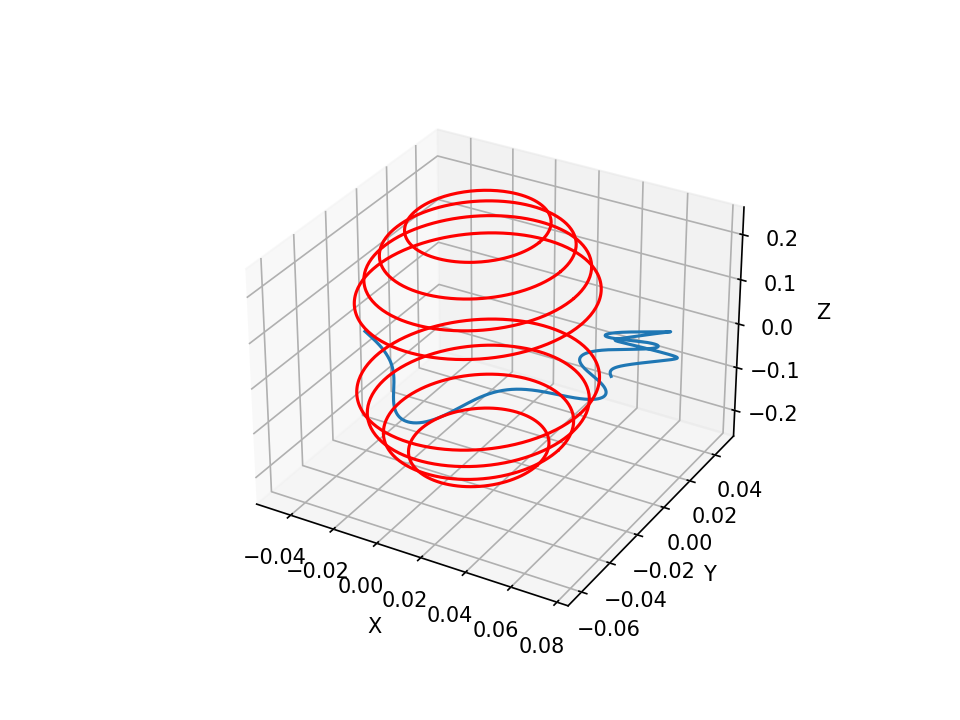

In [33]:
#ploting
# plot in 3D to view trajectory
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.plot3D(xvec, yvec, zvec)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Make some plots of the separatrix
def r_Bz_zero(z):
    rs = 0.05  # [m]
    zs = 0.3  # [m]
    return np.sqrt(rs**2 - z**2*rs**2/zs**2)
z0 = 0
z1 = 0.1
z2 = 0.15
z3 = 0.2
z4 = 0.25
r1 = r_Bz_zero(z1)
r2 = r_Bz_zero(z2)
r3 = r_Bz_zero(z3)
r4 = r_Bz_zero(z4)
thetav1 = np.arange(0, 2 * np.pi, np.pi / 100)

x1, y1 = plotcircle(r1, thetav1)
ax.plot3D(x1, y1, z1, color='red')
ax.plot3D(x1, y1, -z1, color='red')

x2, y2 = plotcircle(r2, thetav1)
ax.plot3D(x2, y2, z2, color='red')
ax.plot3D(x2, y2, -z2, color='red')

x3, y3 = plotcircle(r3, thetav1)
ax.plot3D(x3, y3, z3, color='red')
ax.plot3D(x3, y3, -z3, color='red')

x4, y4 = plotcircle(r4, thetav1)
ax.plot3D(x4, y4, z4, color='red')
ax.plot3D(x4, y4, -z4, color='red')

plt.show()

C:\Users\Jacob\AppData\Local\Temp\ipykernel_54680\3805486369.py:2: RuntimeWarning: overflow encountered in square
  rv = np.sqrt(np.square(xvec) + np.square(yvec))


<IPython.core.display.Javascript object>


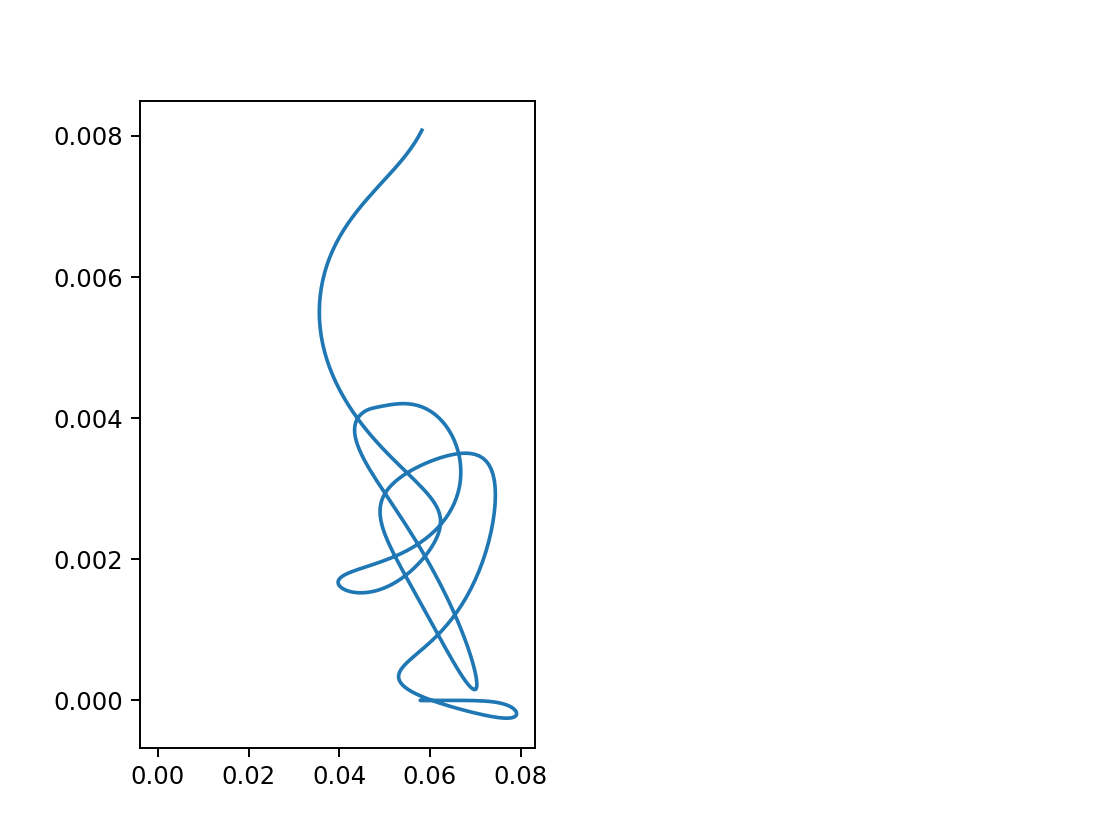

ValueError: Axis limits cannot be NaN or Inf

In [35]:
# r-z plot, x-y plot
rv = np.sqrt(np.square(xvec) + np.square(yvec))
plt.subplot(1, 2, 1)
plt.plot(rv, zvec)
plt.axis([0, max(rv)*1.25, -1.25*max(zvec), 1.25*max(zvec)])
plt.xlabel('r [m]')
plt.ylabel('z [m]')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.plot(xvec, yvec)
plt.axis([-rs*1.1, rs*1.1, -rs*1.1, rs*1.1])
thetav = np.arange(0, 2 * np.pi, np.pi / 100)
x1, y1 = plotcircle(rs, thetav)
plt.plot(x1, y1, 'r--')
thetav2 = np.arange(0, 2 * np.pi, np.pi / 100)
x2, y2 = plotcircle(0.1, thetav2)
plt.plot(x2, y2, 'k--')
plt.axis('equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

In [36]:
initial_KE = 0.5*m*(vxvec[0]**2 + vyvec[0]**2 + vzvec[0]**2)
final_KE = 0.5*m*(vxvec[-1]**2 + vyvec[-1]**2 + vzvec[-1]**2)

print(initial_KE)
print(final_KE)

8.010899999999999e-19
7.553741195434056e-112


C:\Users\Jacob\AppData\Local\Temp\ipykernel_54680\3448952185.py:1: RuntimeWarning: overflow encountered in square
  KE = 0.5*m*(vxvec**2 + vyvec**2 + vzvec**2)/1.6022e-19 # convert to jouls


<IPython.core.display.Javascript object>


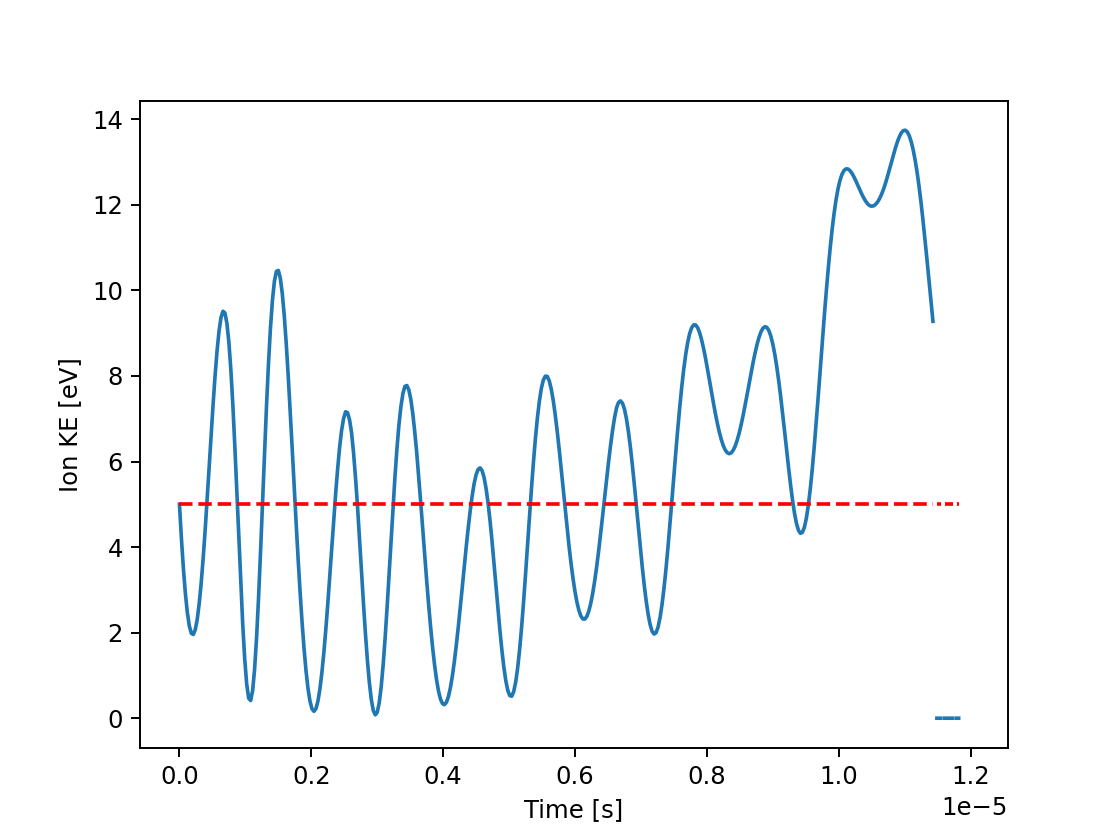

C:\Users\Jacob\AppData\Local\Temp\ipykernel_54680\3448952185.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tnew[:len(KE)], KE[0]*KE/KE, 'r--')


In [37]:
KE = 0.5*m*(vxvec**2 + vyvec**2 + vzvec**2)/1.6022e-19 # convert to jouls 

plt.ylabel('Ion KE [eV]')
plt.xlabel('Time [s]')
plt.plot(tnew[:len(KE)], KE)
plt.plot(tnew[:len(KE)], KE[0]*KE/KE, 'r--')

In [ ]:
b = np.array([[1, 2, 3]])
c = b.copy()
dd = np.concatenate((c, b), axis=0)
print(dd)

In [ ]:
# --------------------------------------------------------------------------------------
# Back to old code 






In [ ]:
# Use this area to debug the new large solver 

# Create A_z_holder
m_array = np.linspace(-4, 4, 9)  # choose modes for AZ
A_Zm_holder = []
for im in range(m_array.shape[0]):
    m = m_array[im]
    A_Zm = np.zeros((nt, nr), dtype ='complex_')  # create A_Z time evolution holder
#     if m == 0:
#         A_Zm[0, :] = 2e-5*np.exp(-(r_array-R/2)**2/.00001) # TODO: remove this, this is to test if 
                                                           # diffusion is working properly  
    A_Zm_holder.append(A_Zm)  # append initial conditions of A_Zm to the list
    
# Create B_z_holder 
n_array = np.linspace(-4, 4, 9) # choose modes for BZ
B_Zn_holder = []

# generate the initial condition for mode n == 0, the Hill's vortex
B_Z_t0 = B0*(1-2*(r_array/R)**2)

# solve for Bz0, used in boundary condition, equation (12) in Quals paper
beta = B_Z_t0[-1]
gamma = np.trapz(B_Z_t0*r_array, dx=dr)
Bz0 = (beta*(rc**2 - R**2) + 2*gamma)/rc**2

# now, load up the list of BZ n-mode matricies 
for i_n in range(n_array.shape[0]):
    n = n_array[i_n]
    B_Zn = np.zeros((nt, nr), dtype ='complex_')  # create B_Z time evolution holder
    if n == 0:   # set up initial condition to be the FRC Hill's vortex at t = 0 for mode n == 0
        B_Zn[0, :] = B_Z_t0
    B_Zn_holder.append(B_Zn)


In [ ]:
# Remove this cell. This is testing for the 
S_m = np.zeros((nr-2, 1), dtype ='complex_')
m = 0
S_m = hall_Az_Sm_updater(m, S_m, A_Zm_holder, B_Zn_holder, n_array, m_array, 0, dt_MHD, dr)


In [ ]:
# Solve for time evolution of system ( be sure to run above cell)
import time 
tic = time.perf_counter()
A_z_holder_out, B_z_holder_out = solve_a_z_b_z(A_Zm_holder, B_Zn_holder, m_array, n_array)
toc = time.perf_counter()
print(f"Run took {toc - tic:0.4f} seconds")

In [ ]:
m = 1
im = np.where(m_array == m)[0][0]
print(im)
toplot='r'

if toplot == 'r':
    for i in range(A_z_holder_out[im].shape[0]):
        plt.plot(r_array, np.real(A_z_holder_out[im][i, :]))
    plt.title(f'Real part of $A_z{m}$ versus radius for different times')
    
if toplot == 'i':
    for i in range(A_z_holder_out[im].shape[0]):
        plt.plot(r_array, np.imag(A_z_holder_out[im][i, :]))
    plt.title(f'Imaginary part of $A_z{m}$ versus radius for different times')
    
plt.xlabel('r [m]')
plt.ylabel(r'$A_z$ [T-m]')

d_skin = np.sqrt(2*eta/(mu0*w_RMF))

plt.axvline(x=(R-d_skin), color='black', linestyle='--')

In [ ]:
fig, ax = plt.subplots() 
plt.title(f'Real part of $A_z{m}$ versus radius for different times')
plt.xlabel('r [m]')
plt.ylabel(r'$A_z$ [T-m]')
def animate2(frame_num):
    #ax.clear()
    plt.plot(r_array, np.real(A_z_holder_out[im][frame_num, :]))
anim = FuncAnimation(fig, animate2, frames=nt, interval=10)

In [ ]:
n = 0
i_n = np.where(n_array == n)[0][0]
print(i_n)
for i in range(B_z_holder_out[i_n].shape[0]):
    plt.plot(r_array, np.real(B_z_holder_out[i_n][i, :]))
plt.title(f'Real part of $B_z,{n}$ versus radius for different times')
plt.xlabel('r [m]')
plt.ylabel(r'$B_{z, n}$ [T-m]')

In [ ]:
# build total A_z = sum_m(A_m): 

A_Z_TOTAL = np.zeros((nt, nr, nphi), dtype ='complex_')
for it in range(t_array.shape[0]):
    print('Percent complete: ', 100*it/t_array.shape[0])
    for ir in range(r_array.shape[0]-1):
        r = dr*ir
        for iphi in range(phi_array.shape[0]):
            phi = iphi*dphi
            for im in range(m_array.shape[0]):
                m = m_array[im]
                A_Z_TOTAL[it, ir, iphi] = A_Z_TOTAL[it, ir, iphi] + \
                                          A_z_holder_out[im][it, ir]*np.exp(1j*m*phi)

In [ ]:
# plot theta 
A_Z_TOTAL_FINAL = A_Z_TOTAL[-1, :, :]
rmesh, phimesh = np.meshgrid(r_array, phi_array)

X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)
#print(A_Z_TOTAL_FINAL)
plt.contourf(X, Y, np.real(A_Z_TOTAL_FINAL), levels=200, cmap='inferno')
plt.title('Visualizing RMF Penetration')
plt.axis('equal')
plt.colorbar()
plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation 
fig, ax = plt.subplots()
plt.axis('equal')
rmesh, phimesh = np.meshgrid(r_array, phi_array)
X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)
minimal_value = np.min(A_Z_TOTAL)
maximal_value = np.max(A_Z_TOTAL)
def animate(frame_num):
    ax.clear()
    A_Z_TOTAL_FRAME = A_Z_TOTAL[frame_num, :, :]
    ax.contourf(X, Y, np.real(A_Z_TOTAL_FRAME), levels=200, cmap='inferno')#, vmin=minimal_value,vmax=maximal_value)
    #ax.colorbar()
anim = FuncAnimation(fig, animate, frames=nt, interval=5)
plt.show()

In [ ]:
term1 = rc**2*Bz0/(rc**2 + R**2)
term2 = 1/(np.pi*(rc**2 - R**2))
b_z = B_Z_t0[1:-1]
b_z.shape = (nr-2, 1)
get_C_plus(nr-2)*(term1 - 2*np.pi*term2*np.trapz(b_z.T*r_array[1:-1], dx=dr))

In [ ]:
vec = 2e-5*np.exp(-(r_array-R/2)**2/.00001)
plt.plot(r_array, vec)

In [ ]:
# solve for modes 0 through 10 
m_array = np.linspace(-5, 5, 11)
A_Zm_holder = []
for im in range(m_array.shape[0]):
    m = m_array[im]
    A_Z = np.zeros((nt, nr), dtype ='complex_')  # create A_Z time evolution holder
    #A_Z[0, :] = -2e-5*np.sin(r_array*2*np.pi/R)*(r_array/R)*(r_array/R - 1) # this is just a place holder
#     if m == 0:
#         A_Z[0, :] = 2e-5*np.exp(-(r_array-R/2)**2/.00001)
    print('Solving for m = ', m)
    A_Zm_holder.append(solve_a_z_m(A_Z, m))

In [ ]:
# build total A_z = sum_m(A_m): 

A_Z_TOTAL = np.zeros((nt, nr, nphi), dtype ='complex_')
for it in range(t_array.shape[0]):
    print('Percent complete: ', 100*it/t_array.shape[0])
    for ir in range(r_array.shape[0]-1):
        r = dr*ir
        for iphi in range(phi_array.shape[0]):
            phi = iphi*dphi
            for im in range(m_array.shape[0]):
                m = m_array[im]
                A_Z_TOTAL[it, ir, iphi] = A_Z_TOTAL[it, ir, iphi] + \
                                          A_Zm_holder[im][it, ir]*np.exp(1j*m*phi)



In [ ]:
print(A_Z_TOTAL[30, -1, :])

In [ ]:
# plot theta 
A_Z_TOTAL_FINAL = A_Z_TOTAL[-1, :, :]
rmesh, phimesh = np.meshgrid(r_array, phi_array)

X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)
#print(A_Z_TOTAL_FINAL)
plt.contourf(X, Y, np.real(A_Z_TOTAL_FINAL), levels=200, cmap='inferno')
plt.title('Visualizing RMF Penetration')
plt.axis('equal')
plt.colorbar()
plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation 
fig, ax = plt.subplots()
plt.axis('equal')
rmesh, phimesh = np.meshgrid(r_array, phi_array)
X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)
minimal_value = np.min(A_Z_TOTAL)
maximal_value = np.max(A_Z_TOTAL)
def animate(frame_num):
    ax.clear()
    A_Z_TOTAL_FRAME = A_Z_TOTAL[frame_num, :, :]
    ax.contourf(X, Y, np.real(A_Z_TOTAL_FRAME), levels=200, cmap='inferno')#, vmin=minimal_value,vmax=maximal_value)
    #ax.colorbar()
anim = FuncAnimation(fig, animate, frames=nt, interval=5)
plt.show()
    
    
    

In [ ]:
%matplotlib notebook 
m = 1
im = np.where(m_array == m)[0][0]
print(im)
for i in range(A_Zm_holder[im].shape[0]):
    plt.plot(r_array, np.real(A_Zm_holder[im][i, :]))
plt.title(f'Real part of $A_z{m}$ versus radius for different times')
plt.xlabel('r [m]')
plt.ylabel(r'$A_z$ [T-m]')

d_skin = np.sqrt(2*eta/(mu0*w_RMF))

plt.axvline(x=(R-d_skin), color='black', linestyle='--')

In [ ]:
fig, ax = plt.subplots() 
plt.title(f'Real part of $A_z{m}$ versus radius for different times')
plt.xlabel('r [m]')
plt.ylabel(r'$A_z$ [T-m]')
def animate2(frame_num):
    #ax.clear()
    plt.plot(r_array, np.real(A_Zm_holder[im][frame_num, :]))
anim = FuncAnimation(fig, animate2, frames=nt, interval=10)

In [ ]:
fig, ax = plt.subplots() 
plt.title(f'Real part of $A_z{m}$ versus radius for different times')
plt.xlabel('r [m]')
plt.ylabel(r'$A_z$ [T-m]')
def animate2(frame_num):
    #ax.clear()
    plt.plot(r_array, np.real(A_Zm_holder[im][frame_num, :]))
anim = FuncAnimation(fig, animate2, frames=nt, interval=10)

In [ ]:
for i in range(A_Zm_holder[m].shape[0]): 
    plt.plot(r_array, np.imag(A_Zm_holder[m][i, :]))
plt.title(r'Imaginary part of $A_z$ versus radius for different times')
plt.xlabel('r [m]')
plt.ylabel(r'$A_z$ [T-m]')

d_skin = np.sqrt(2*eta/(mu0*w_RMF))

plt.axvline(x=(R-d_skin), color='black', linestyle='--')

In [ ]:
# -------------- 
#  Testing area for B functionality
# --------------

# initial condition for n == 0 mode: Hill's vortex
B_Z_t0 = B0*(1-2*(r_array/R)**2)

# solve for Bz0, used in boundary condition, equation (12) in Quals paper
beta = B_Z_t0[-1]
gamma = np.trapz(B_Z_t0*r_array, dx=dr)
Bz0 = (beta*(rc**2 - R**2) + 2*gamma)/rc**2
#Bz0 = -B0*1.2 #TODA: remove


plt.plot(r_array, B_Z_t0, color='green', label=r'$B_{z, n=0}$')
plt.plot(r_array, B_Z_t0*0, 'r--')
plt.title(r'Initial $B_{z, n=0}$')
plt.xlabel('r [m]')
plt.ylabel(r'$B_{z, n=0}$')
plt.legend()
print(Bz0)


In [ ]:
# solve for B_z modes 
n_array = np.linspace(-5, 5, 11)
B_Zn_holder = []
for i_n in range(n_array.shape[0]):
    n = n_array[i_n]
    B_Z = np.zeros((nt, nr), dtype ='complex_')  # create B_Z time evolution holder
    if n == 0:   # set up initial condition to be the FRC Hill's vortex at t = 0 for mode n == 0
        B_Z[0, :] = B_Z_t0
    print('Solving for n = ', n)
    B_Zn_holder.append(solve_b_z_n(B_Z, n))

In [ ]:
%matplotlib notebook 
n = 0
i_n = np.where(n_array == n)[0][0]
print(i_n)
for i in range(B_Zn_holder[i_n].shape[0]):
    plt.plot(r_array, np.real(B_Zn_holder[i_n][i, :]))
plt.title(f'Real part of $B_z,{n}$ versus radius for different times')
plt.xlabel('r [m]')
plt.ylabel(r'$B_{z, n}$ [T-m]')

In [ ]:
print(Bz0)

In [ ]:
fig, ax = plt.subplots() 
plt.title(f'Real part of $A_z{m}$ versus radius for different times')
plt.xlabel('r [m]')
plt.ylabel(r'$A_z$ [T-m]')
def animate3(frame_num):
    ax.clear()
    plt.ylim([2*B_Z_t0[0], 2*B_Z_t0[-1]])
    plt.plot(r_array, np.real(B_Zn_holder[i_n][frame_num, :]))
anim = FuncAnimation(fig, animate3, frames=nt, interval=5)

In [ ]:
# build total B_z = sum_m(A_m): 

B_Z_TOTAL = np.zeros((nt, nr, nphi), dtype ='complex_')
for it in range(t_array.shape[0]):
    print('Percent complete: ', 100*it/t_array.shape[0])
    for ir in range(r_array.shape[0]-1):
        r = dr*ir
        for iphi in range(phi_array.shape[0]):
            phi = iphi*dphi
            for i_n in range(n_array.shape[0]):
                n = n_array[i_n]
                B_Z_TOTAL[it, ir, iphi] = B_Z_TOTAL[it, ir, iphi] + \
                                          B_Zn_holder[i_n][it, ir]*np.exp(1j*n*phi)

In [ ]:
# plot theta 
B_Z_TOTAL_FINAL = B_Z_TOTAL[-1, :, :]
rmesh, phimesh = np.meshgrid(r_array, phi_array)

X = rmesh.T * np.cos(phimesh.T)
Y = rmesh.T * np.sin(phimesh.T)
#print(A_Z_TOTAL_FINAL)
plt.contourf(X, Y, np.real(B_Z_TOTAL_FINAL), levels=200, cmap='viridis')
plt.title('Visualizing RMF Penetration')
plt.axis('equal')
plt.colorbar()
plt.show()